<a href="https://colab.research.google.com/github/pandian-raja/EVA4_Session15/blob/master/Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/pandian-raja/EVA4_Session15/master/GetData2.py

--2020-06-01 14:57:36--  https://raw.githubusercontent.com/pandian-raja/EVA4_Session15/master/GetData2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2765 (2.7K) [text/plain]
Saving to: ‘GetData2.py’

GetData2.py         100%[===================>]   2.70K  --.-KB/s    in 0s      

2020-06-01 14:57:36 (25.3 MB/s) - ‘GetData2.py’ saved [2765/2765]



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install tensorboardX

     |████████████████████████████████| 204kB 4.9MB/s 


In [210]:
!pip install kornia
from kornia.losses import SSIM

     |████████████████████████████████| 163kB 2.6MB/s 


In [0]:
import os
import torch
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
import torchvision
from torch import nn
import torch
import shutil
from zipfile import ZipFile 
import zipfile
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

%reload_ext autoreload
%autoreload 2

In [21]:
!pip install torchsummary
from torchsummary import summary


In [0]:
import GetData2 as gd

In [6]:
train_loader = gd.importDataset()


40000
40000
40000
40000


In [7]:
sample = next(iter(train_loader))
[(k, v.shape) for k, v in sample.items()]


[('f1', torch.Size([12, 3, 128, 128])),
 ('f2', torch.Size([12, 3, 128, 128])),
 ('f3', torch.Size([12, 3, 128, 128])),
 ('f4', torch.Size([12, 3, 128, 128]))]

In [0]:
device = torch.device('cuda:0')


In [0]:
def show(tensors, figsize=(10, 10), *args, **kwargs):
    try:
        tensors = tensors.detach().cpu()
    except:
        pass
    grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)
    grid_image = grid_tensor.permute(1, 2, 0)
    plt.figure(figsize=figsize)
    plt.imshow(grid_image)
    plt.xticks([])
    plt.yticks([])

    plt.show()

In [0]:
def show_pred(tensors, *args, **kwargs):
    mean, std = torch.tensor([0.485, 0.456, 0.406])*255, torch.tensor([0.229, 0.224, 0.225])*255
    tensors = (tensors * std[None, :, None, None]) + mean[None, :, None, None]
    show(tensors, *args, **kwargs)

In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



In [0]:
class upconv(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size, scale):
        super(upconv, self).__init__()
        self.scale = scale
        self.conv1 = nn.Sequential(nn.Conv2d(num_in_layers,num_out_layers,kernel_size,padding=1), 
                                   nn.BatchNorm2d(num_out_layers), 
                                   nn.ReLU())

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return self.conv1(x)

In [0]:

class ResNetInspired(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetInspired, self).__init__()
        self.in_planes = 64
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, stride=1, padding=1, bias=False, groups=32),
            nn.Conv2d(32, 32, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        # self.convblock5 = nn.Sequential(
        #     nn.Conv2d(128, 3, 3, stride=1, padding=1, bias=False),
        # )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(128, 3, 3, stride=1, padding=1, bias=False),
        )

        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, 1, stride=1)
        self.layer2 = self._make_layer(block, 128, 1, stride=2)
        self.layer3 = self._make_layer(block, 256, 1, stride=2)
        self.layer4 = self._make_layer(block, 512, 1, stride=2)
        self.layer5 = self._make_layer(block, 1024, 1, stride=2)
        self.upconv1 = upconv(1024, 512, 3, 2)
        self.upconv2 = upconv(512, 256, 3, 2)
        self.upconv3 = upconv(256, 128, 3, 2)
        self.upconv4 = upconv(128, 64, 3, 2)
        self.concatConv1 =  nn.Sequential( nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1, bias=False),
                                          nn.BatchNorm2d(512),
                                                         nn.ReLU())
        self.concatConv2 = nn.Sequential( nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                         nn.BatchNorm2d(256),
                                                         nn.ReLU())
        self.concatConv3 = nn.Sequential( nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                                         nn.ReLU())
        self.concatConv4 = nn.Sequential( nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                                         nn.ReLU())



    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):

        f1 = self.convblock2(self.convblock1(x["f1"]))
        f2 = self.convblock2(self.convblock1(x["f2"]))
        # f = f2-f1
        # f2 = self.convblock2(self.convblock1(x))
        # f1 = self.convblock2(self.convblock1(x))
        # f1 = x['f1']
        # f2 = x['f2']
        concat = torch.cat((f1, f2), 1)
        # print("conv shape:"+str(concat.shape))
        # 
        # out = F.relu(self.bn1(self.conv1(f)))
        mask = self.convblock4(self.convblock3(concat))
        # print("mask shape:"+str(mask.shape))
        out = F.relu(self.bn1(self.conv1(concat)))
        # print("out shape:"+str(out.shape))
        out1  = self.layer1(out)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        skip1= out1
        skip2= out2
        skip3= out3
        skip4= out4
        skip5= out5
        # print("skip1 shape:"+str(skip1.shape))
        # print("skip2 shape:"+str(skip2.shape))
        # print("skip3 shape:"+str(skip3.shape))
        # print("skip4 shape:"+str(skip4.shape))
        # print("skip5 shape:"+str(skip5.shape))        
        up1 = self.upconv1(out5)
        # print("Up1 Shape"+str(up1.shape))

        concatup1 = torch.cat((up1, skip4), 1)
        concatup1 = self.concatConv1(concatup1)
        # print("Concat1 Shape"+str(concatup1.shape))
        
        up2 = self.upconv2(concatup1)
        # print("Up2 Shape"+str(up2.shape))
        concatup2 = torch.cat((up2, skip3), 1)
        concatup2 = self.concatConv2(concatup2)
        # print("Concat2 Shape"+str(concatup2.shape))

        up3 = self.upconv3(concatup2)
        # print("Up3 Shape"+str(up3.shape))
        concatup3 = torch.cat((up3, skip2), 1)
        concatup3 = self.concatConv3(concatup3)
        # print("Concat3 Shape"+str(concatup3.shape))

        up4 = self.upconv4(concatup3)
        # print("Up4 Shape"+str(up4.shape))
        concatup4 = torch.cat((up4, skip1), 1)
        concatup4 = self.concatConv4(concatup4)
        # print("Concat4 Shape"+str(concatup4.shape))

        # out=up4
        out = self.convblock4(concatup4)
        return mask,out


In [0]:
model = ResNetInspired(BasicBlock, [1,1,1,1]).to(device)
# summary(model, (3, 128, 128))

In [0]:
torch.cuda.empty_cache()

In [0]:
epoch=1
def train(model, criterion, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data["f1"] = data["f1"].to(device)
        data["f2"] = data["f2"].to(device)
        data["f3"] = data["f3"].to(device)
        data["f4"] = data["f4"].to(device)
        optim.zero_grad()
        output = model(data)
        loss1 = criterion(output[0], data["f3"])
        loss2 = criterion(output[1], data["f4"])
        loss = loss1+ 2*loss2
        loss.backward()
        optim.step()
        if batch_idx % 100 == 0:
            print(loss1)
            print(loss2)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.*batch_idx/ len(train_loader), loss.item()))
            print('Batch ID:', batch_idx)
            img_grid1 = tensorboardImage(output[0].detach().cpu(), nrow=2) #nrow = sqrt-bs
            img_grid2 = tensorboardImage(output[1].detach().cpu(), nrow=2) #nrow = sqrt-bs
            writer.add_image('Mask', img_grid1)
            writer.add_image('Depth', img_grid2)
            show_pred(output[0].detach().cpu(), nrow=2) #nrow = sqrt-bs
            show_pred(output[1].detach().cpu(), nrow=2) #nrow = sqrt-bs
            
            # if batch_idx % 500 == 0:
            #     torch.save(model.sate_dict(), PATH/f"{batch_idx}.pth")
        


tensor(0.3865, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6711, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [0/40000 (0%)]	 Loss: 1.728707
Batch ID: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


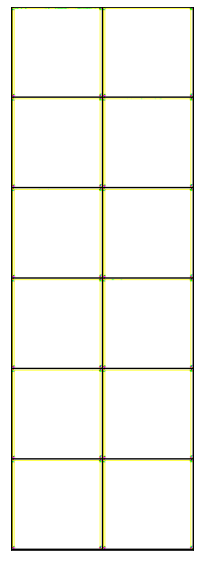

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


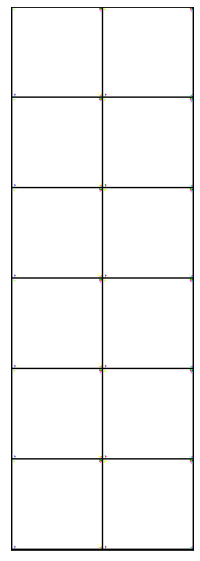

tensor(0.2536, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6214, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [400/40000 (3%)]	 Loss: 1.496523
Batch ID: 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


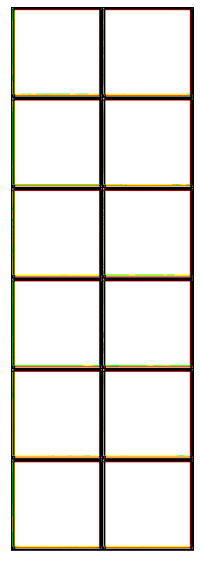

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


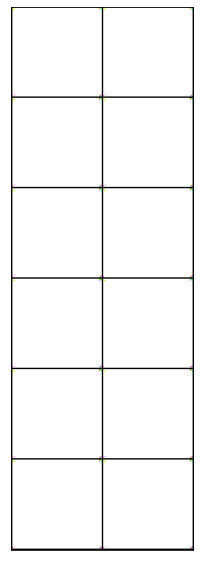

tensor(0.2333, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6710, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [800/40000 (6%)]	 Loss: 1.575250
Batch ID: 200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


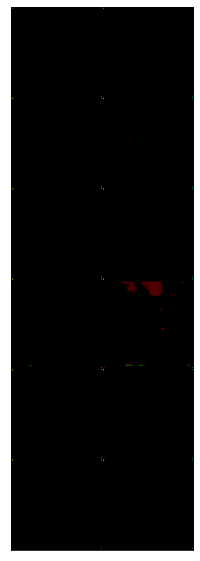

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


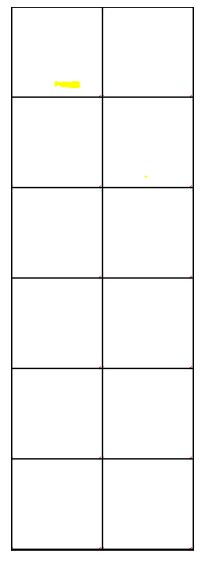

tensor(0.2118, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6512, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [1200/40000 (9%)]	 Loss: 1.514273
Batch ID: 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


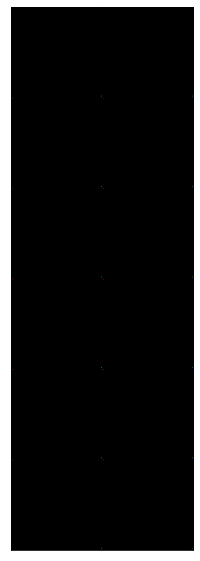

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


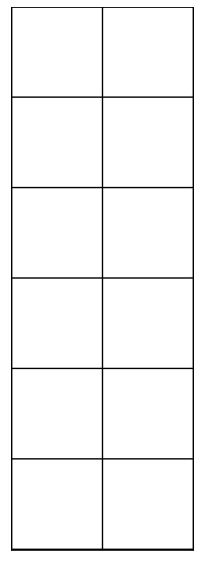

tensor(0.2148, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6366, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [1600/40000 (12%)]	 Loss: 1.488018
Batch ID: 400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


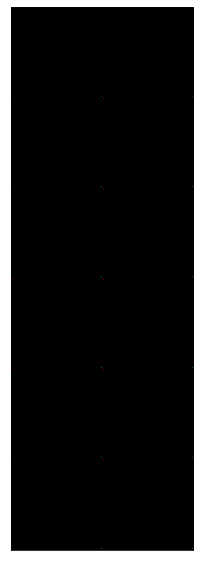

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


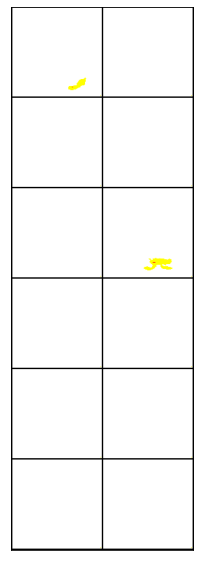

tensor(0.1919, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6540, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [2000/40000 (15%)]	 Loss: 1.499919
Batch ID: 500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


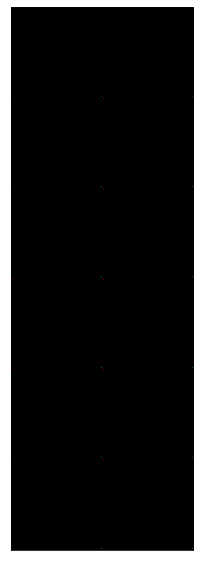

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


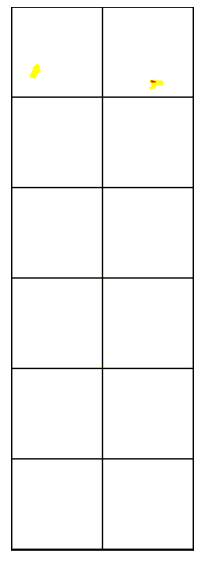

tensor(0.2309, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6391, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [2400/40000 (18%)]	 Loss: 1.509075
Batch ID: 600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


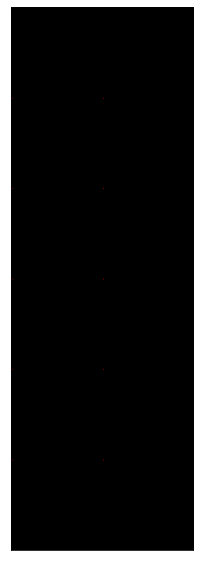

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


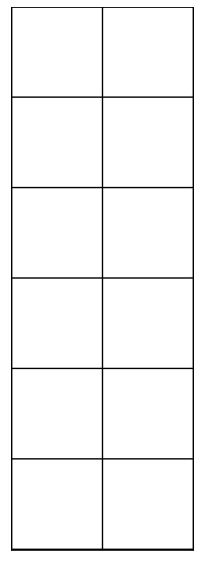

tensor(0.2101, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6340, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [2800/40000 (21%)]	 Loss: 1.478118
Batch ID: 700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


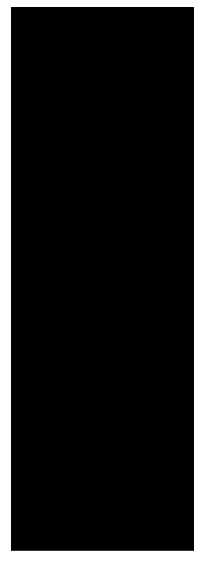

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


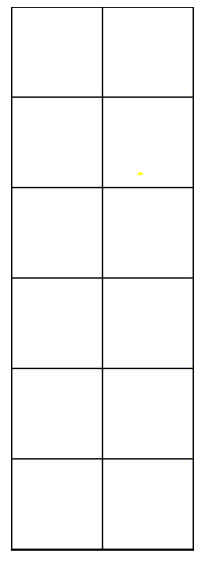

tensor(0.1586, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6337, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [3200/40000 (24%)]	 Loss: 1.426040
Batch ID: 800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


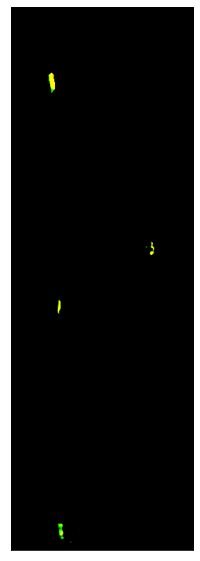

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


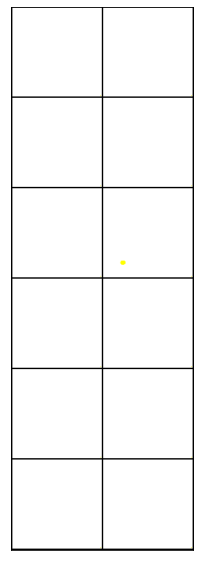

tensor(0.1961, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6417, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [3600/40000 (27%)]	 Loss: 1.479455
Batch ID: 900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


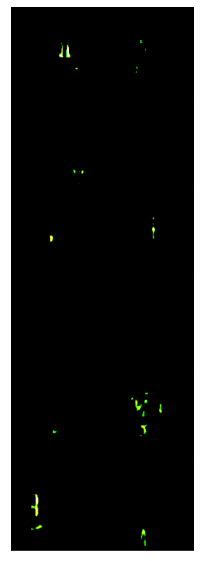

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


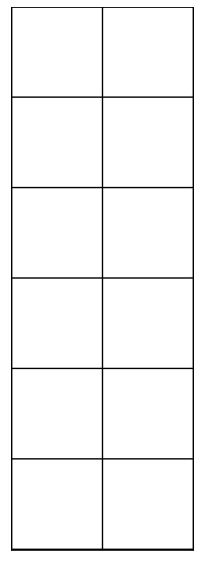

tensor(0.1759, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6330, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [4000/40000 (30%)]	 Loss: 1.441960
Batch ID: 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


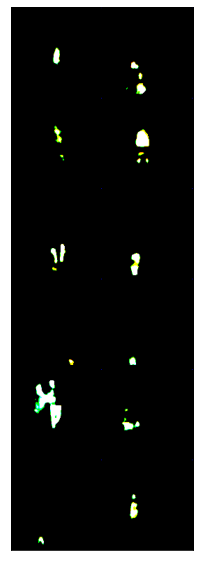

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


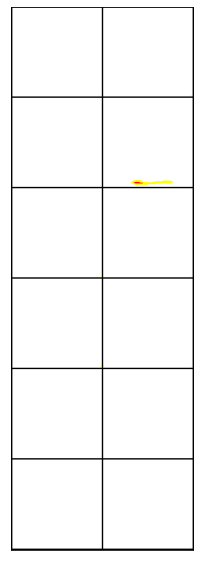

tensor(0.2137, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6437, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [4400/40000 (33%)]	 Loss: 1.501004
Batch ID: 1100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


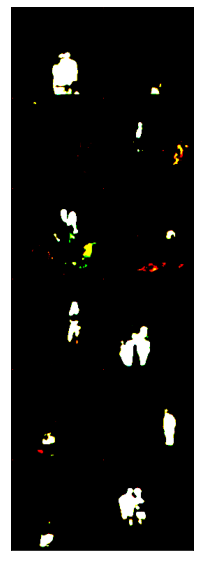

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


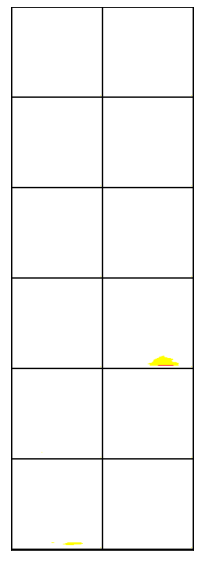

tensor(0.1313, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6312, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [4800/40000 (36%)]	 Loss: 1.393798
Batch ID: 1200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


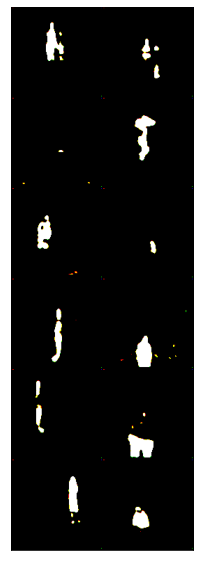

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


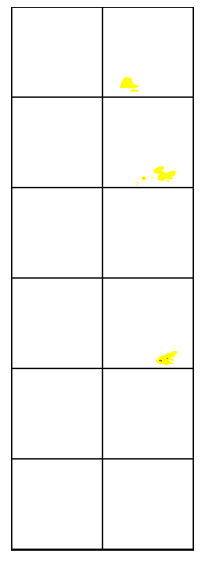

tensor(0.1334, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6418, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [5200/40000 (39%)]	 Loss: 1.417060
Batch ID: 1300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


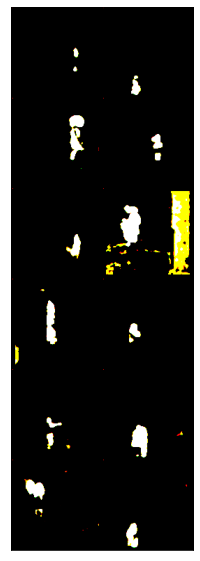

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


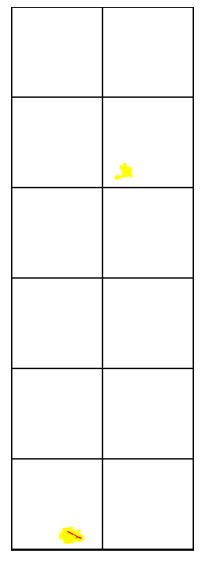

tensor(0.1402, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6239, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [5600/40000 (42%)]	 Loss: 1.387970
Batch ID: 1400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


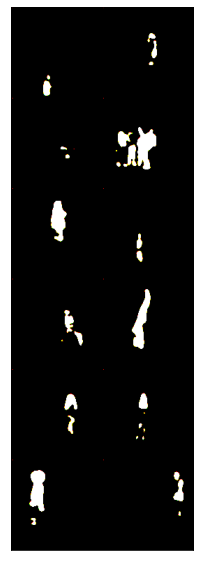

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


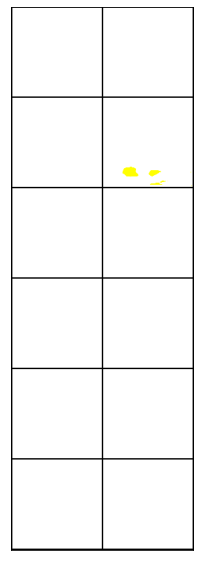

tensor(0.1587, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6242, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [6000/40000 (45%)]	 Loss: 1.407199
Batch ID: 1500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


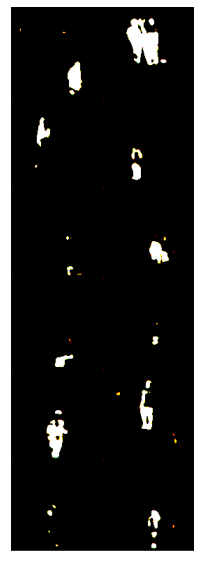

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


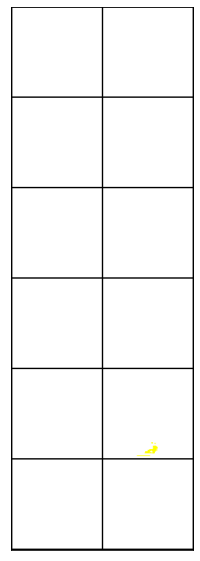

tensor(0.1299, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6386, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [6400/40000 (48%)]	 Loss: 1.407113
Batch ID: 1600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


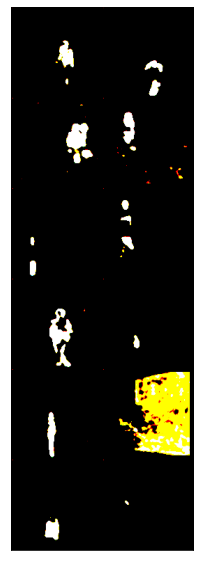

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


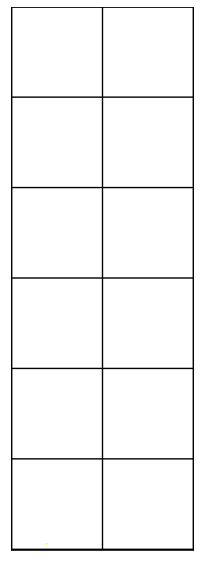

tensor(0.1383, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6116, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [6800/40000 (51%)]	 Loss: 1.361526
Batch ID: 1700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


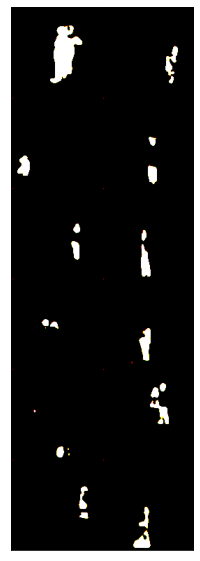

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


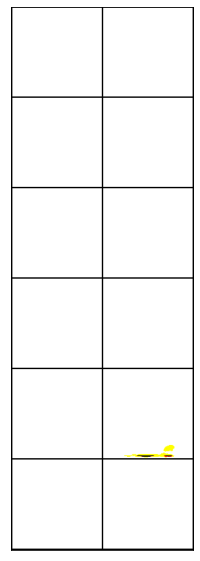

tensor(0.0926, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6103, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [7200/40000 (54%)]	 Loss: 1.313261
Batch ID: 1800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


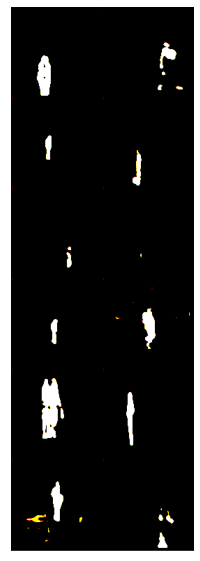

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


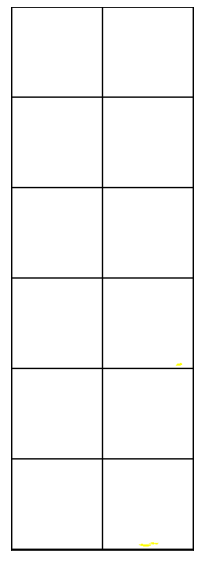

tensor(0.1475, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6494, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [7600/40000 (57%)]	 Loss: 1.446297
Batch ID: 1900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


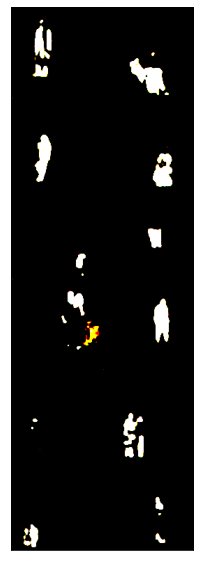

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


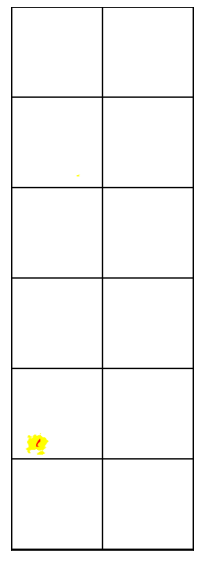

tensor(0.0900, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6159, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [8000/40000 (60%)]	 Loss: 1.321727
Batch ID: 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


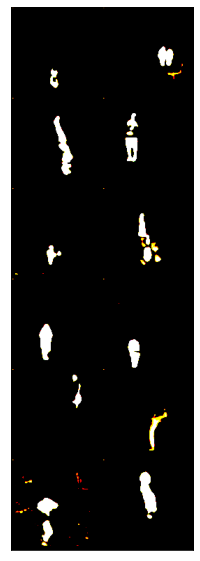

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


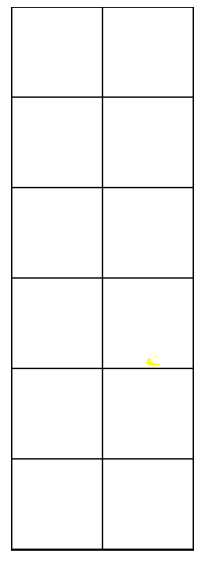

tensor(0.1174, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6339, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [8400/40000 (63%)]	 Loss: 1.385092
Batch ID: 2100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


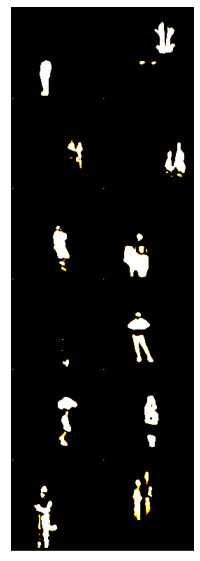

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


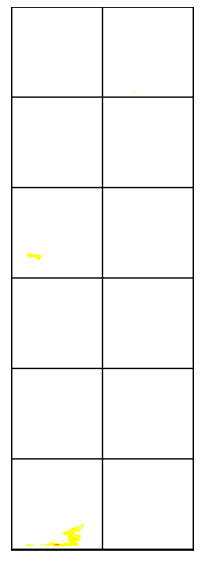

tensor(0.1190, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6362, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [8800/40000 (66%)]	 Loss: 1.391387
Batch ID: 2200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


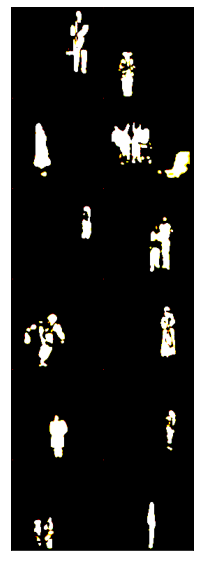

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


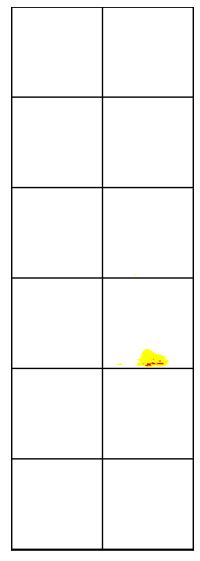

tensor(0.1044, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6321, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [9200/40000 (69%)]	 Loss: 1.368605
Batch ID: 2300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


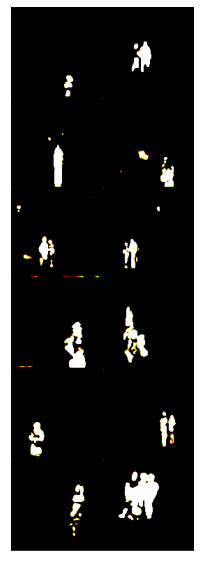

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


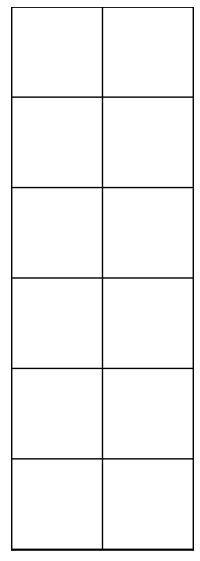

tensor(0.0892, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6373, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [9600/40000 (72%)]	 Loss: 1.363732
Batch ID: 2400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


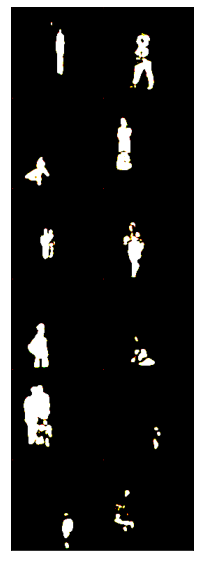

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


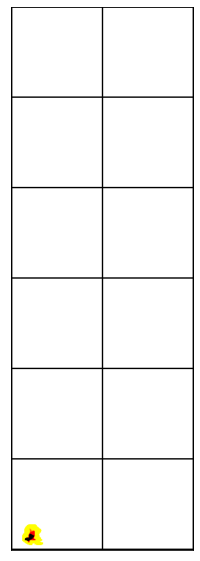

tensor(0.1001, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6371, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [10000/40000 (75%)]	 Loss: 1.374260
Batch ID: 2500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


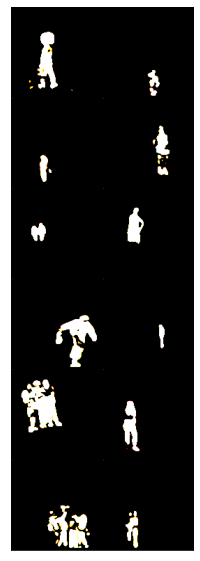

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


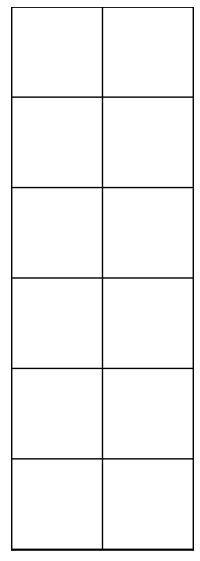

tensor(0.1163, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6335, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [10400/40000 (78%)]	 Loss: 1.383399
Batch ID: 2600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


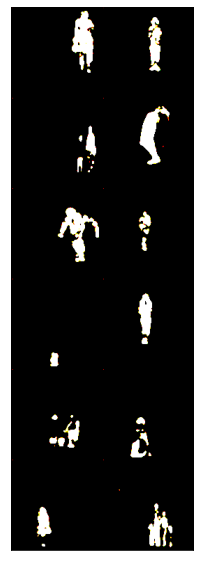

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


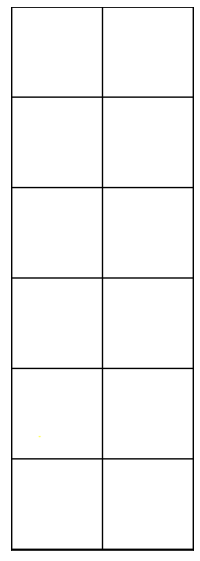

tensor(0.1115, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6442, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [10800/40000 (81%)]	 Loss: 1.399844
Batch ID: 2700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


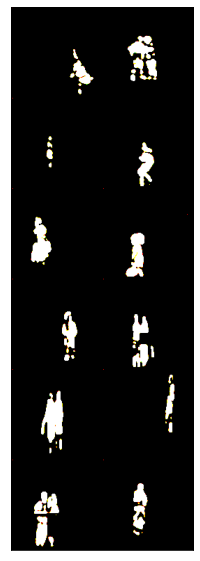

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


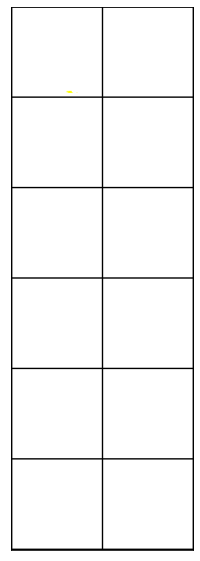

tensor(0.0948, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6204, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [11200/40000 (84%)]	 Loss: 1.335692
Batch ID: 2800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


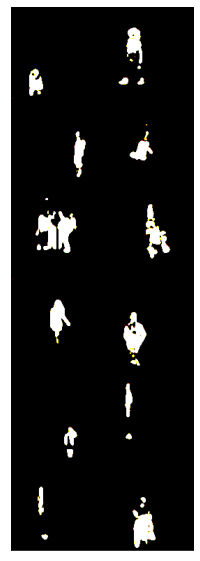

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


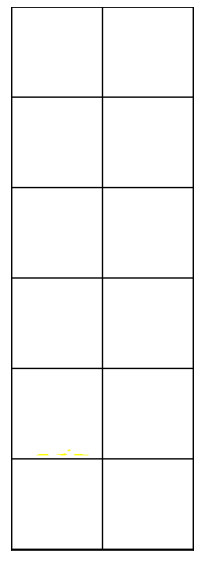

tensor(0.0815, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6252, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [11600/40000 (87%)]	 Loss: 1.331856
Batch ID: 2900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


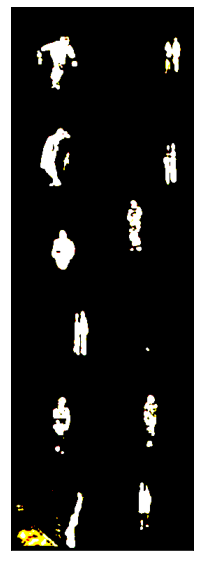

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


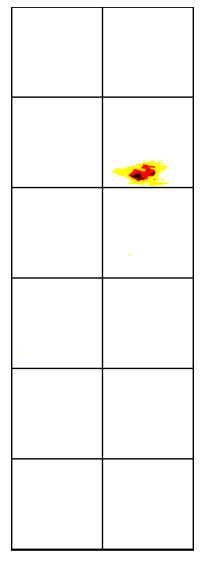

tensor(0.0974, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6051, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [12000/40000 (90%)]	 Loss: 1.307507
Batch ID: 3000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


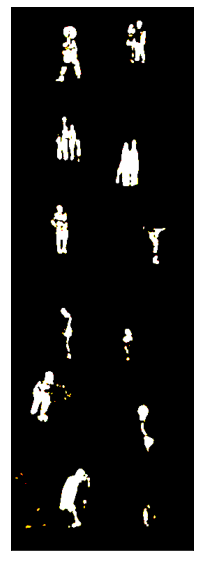

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


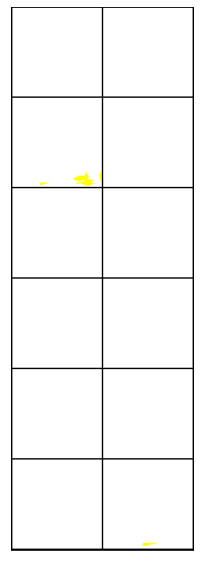

tensor(0.1125, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6262, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [12400/40000 (93%)]	 Loss: 1.365026
Batch ID: 3100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


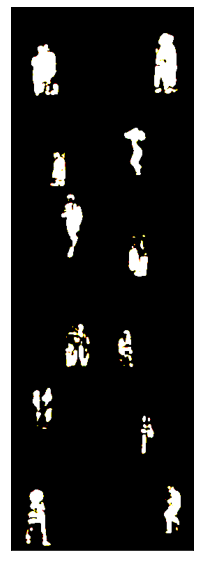

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


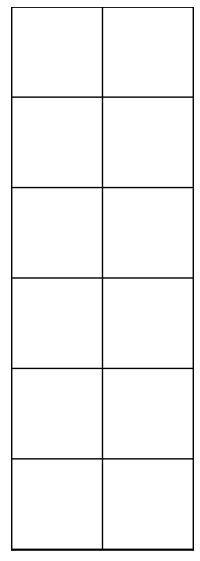

tensor(0.0953, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6126, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [12800/40000 (96%)]	 Loss: 1.320454
Batch ID: 3200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


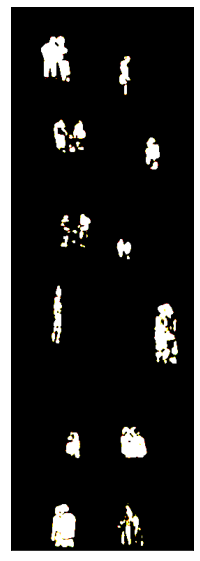

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


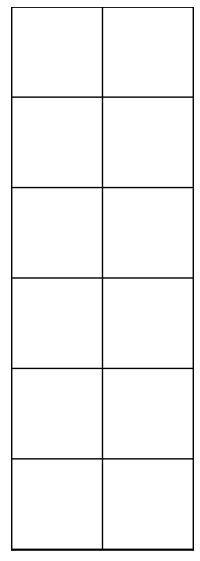

tensor(0.0958, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6224, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [13200/40000 (99%)]	 Loss: 1.340583
Batch ID: 3300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


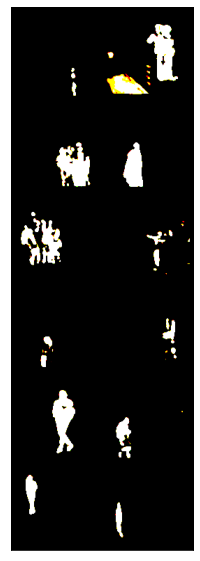

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


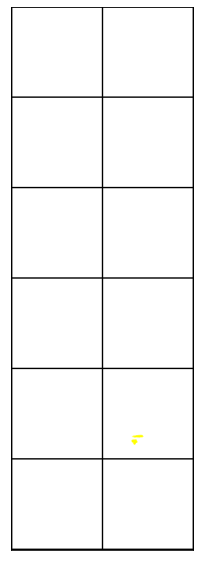

tensor(0.0735, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [0/40000 (0%)]	 Loss: 1.327003
Batch ID: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


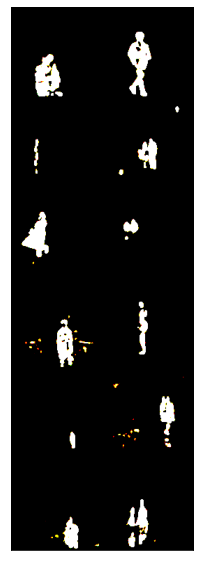

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


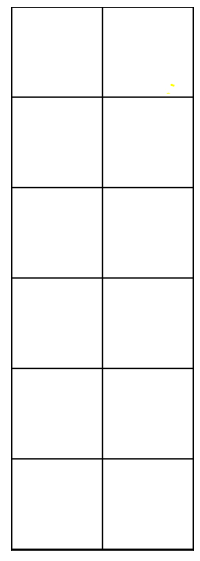

tensor(0.0824, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6300, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [400/40000 (3%)]	 Loss: 1.342328
Batch ID: 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


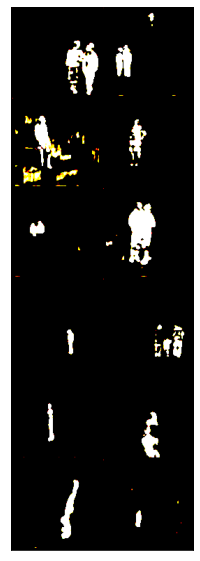

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


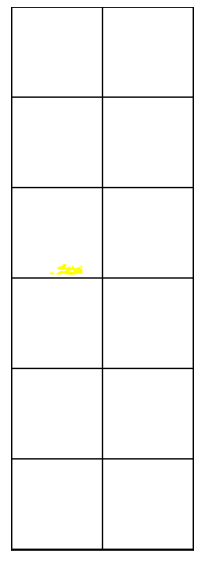

tensor(0.0876, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6503, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [800/40000 (6%)]	 Loss: 1.388187
Batch ID: 200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


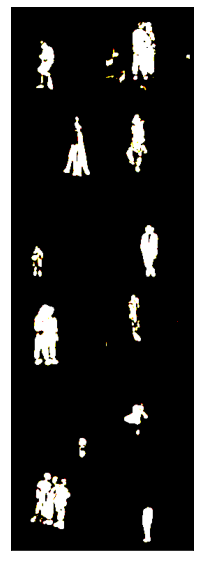

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


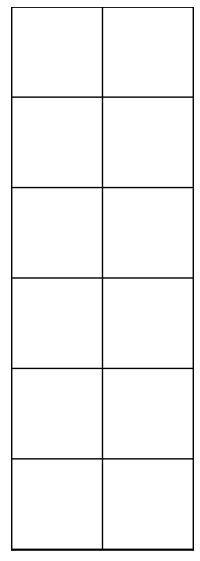

tensor(0.0943, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6410, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [1200/40000 (9%)]	 Loss: 1.376268
Batch ID: 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


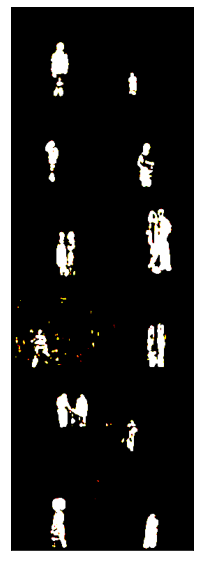

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


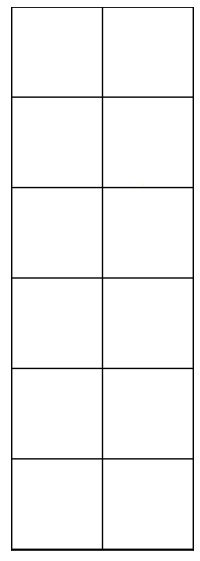

tensor(0.0747, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6182, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [1600/40000 (12%)]	 Loss: 1.311117
Batch ID: 400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


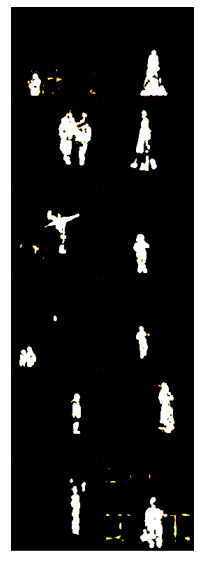

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


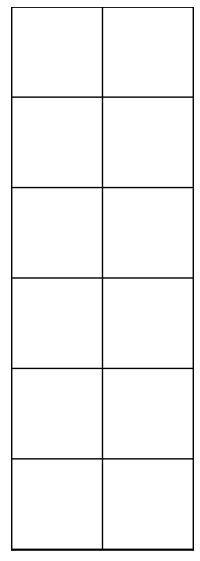

tensor(0.0704, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6058, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [2000/40000 (15%)]	 Loss: 1.281985
Batch ID: 500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


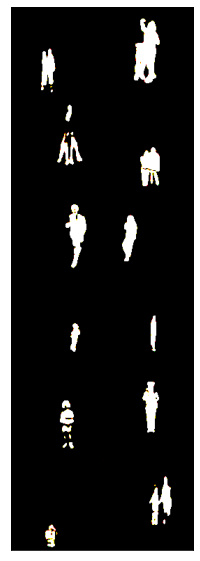

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


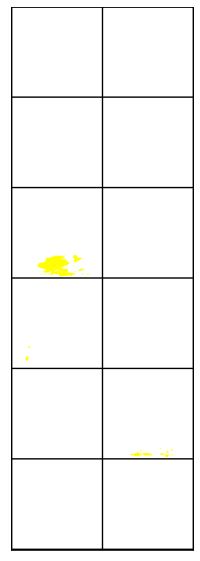

tensor(0.0769, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6165, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [2400/40000 (18%)]	 Loss: 1.309926
Batch ID: 600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


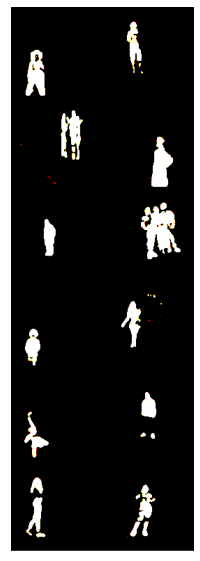

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


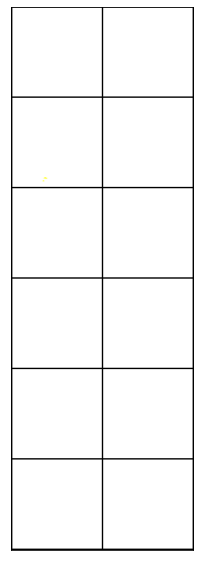

tensor(0.0804, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6475, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [2800/40000 (21%)]	 Loss: 1.375404
Batch ID: 700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


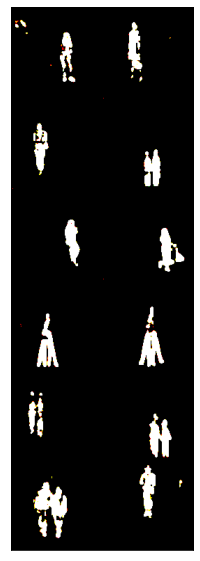

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


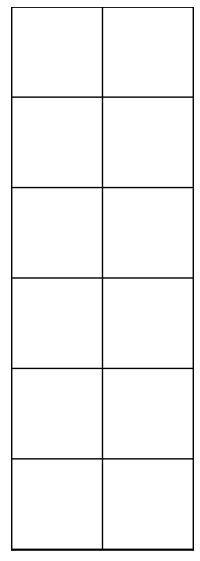

tensor(0.0855, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [3200/40000 (24%)]	 Loss: 1.277170
Batch ID: 800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


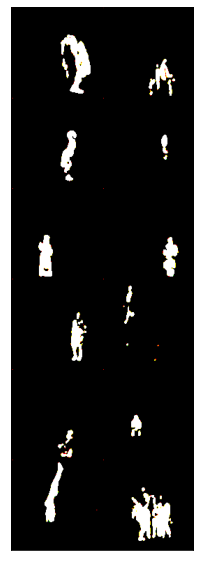

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


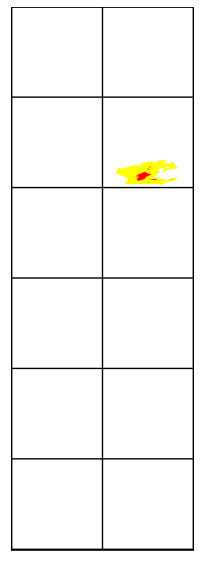

tensor(0.0765, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6479, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [3600/40000 (27%)]	 Loss: 1.372268
Batch ID: 900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


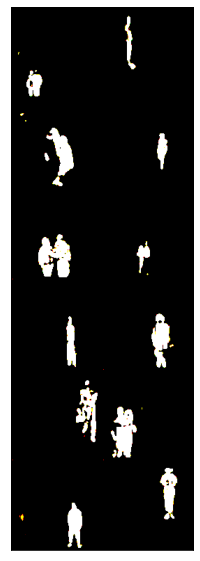

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


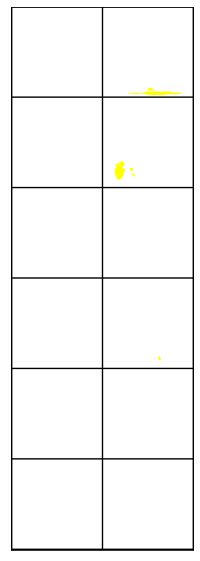

tensor(0.0672, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6378, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [4000/40000 (30%)]	 Loss: 1.342807
Batch ID: 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


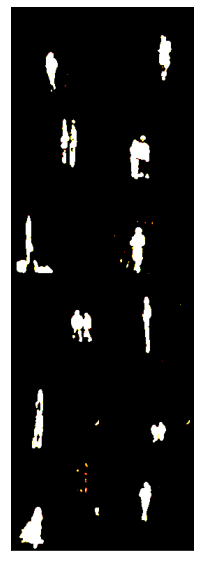

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


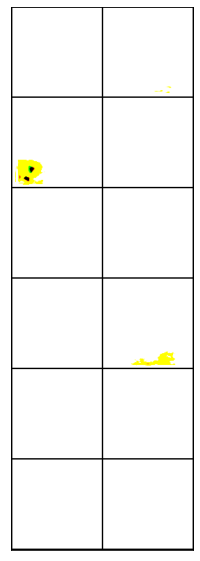

tensor(0.0581, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6144, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [4400/40000 (33%)]	 Loss: 1.286826
Batch ID: 1100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


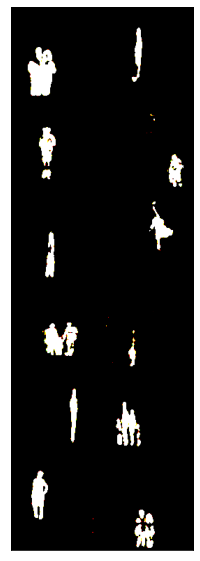

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


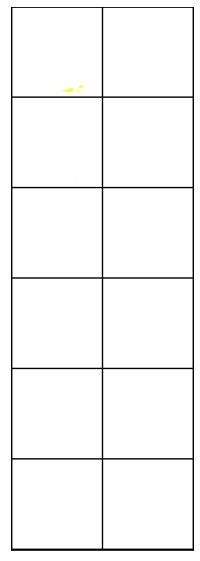

tensor(0.0712, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6138, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [4800/40000 (36%)]	 Loss: 1.298754
Batch ID: 1200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


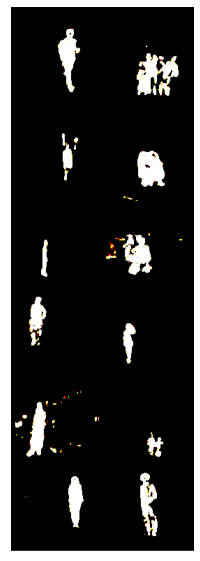

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


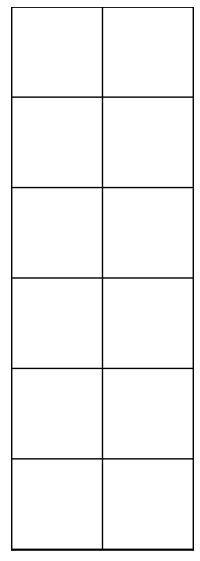

tensor(0.0724, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6287, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [5200/40000 (39%)]	 Loss: 1.329831
Batch ID: 1300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


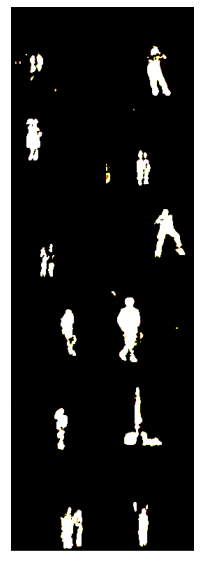

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


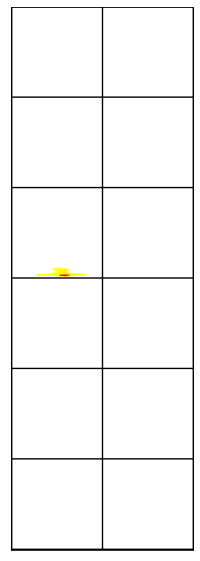

tensor(0.0639, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6098, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [5600/40000 (42%)]	 Loss: 1.283469
Batch ID: 1400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


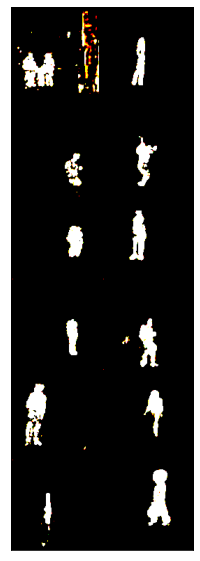

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


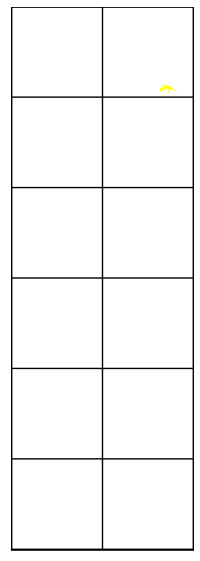

tensor(0.0706, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6363, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [6000/40000 (45%)]	 Loss: 1.343284
Batch ID: 1500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


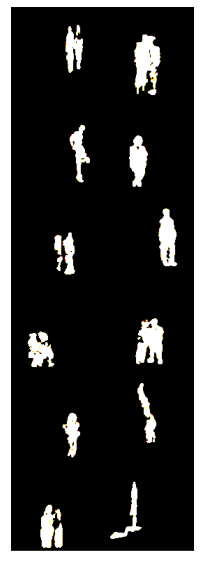

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


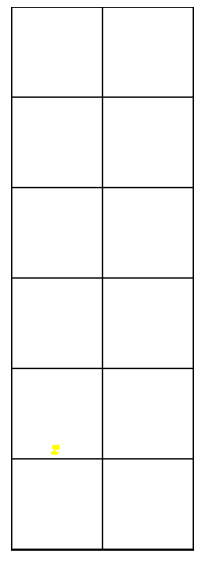

tensor(0.0603, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6465, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [6400/40000 (48%)]	 Loss: 1.353335
Batch ID: 1600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


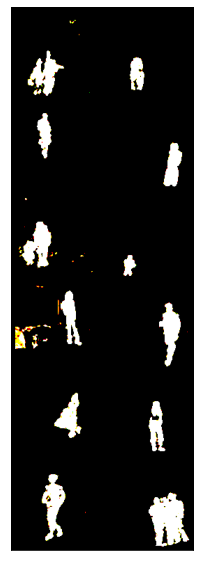

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


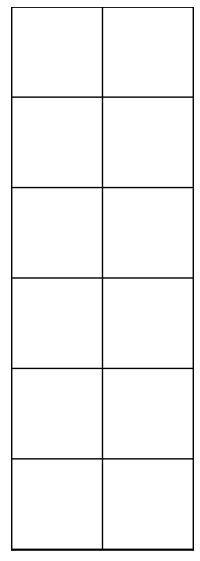

tensor(0.0594, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6322, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [6800/40000 (51%)]	 Loss: 1.323737
Batch ID: 1700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


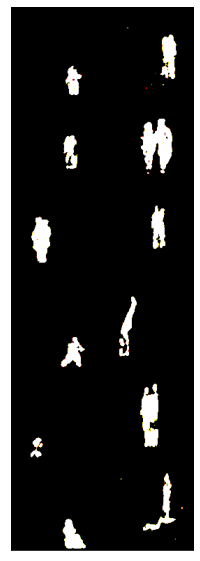

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


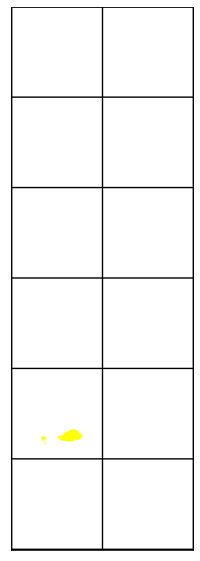

tensor(0.0615, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6298, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [7200/40000 (54%)]	 Loss: 1.321146
Batch ID: 1800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


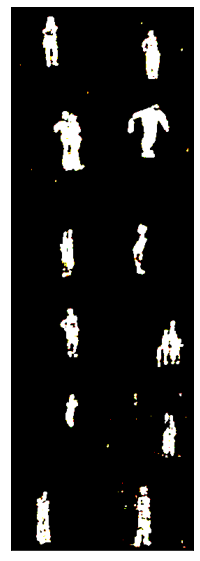

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


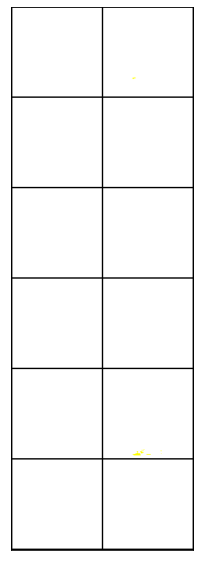

tensor(0.0474, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6574, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [7600/40000 (57%)]	 Loss: 1.362292
Batch ID: 1900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


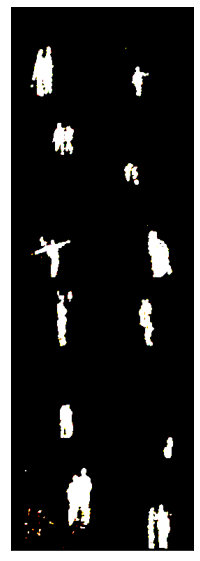

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


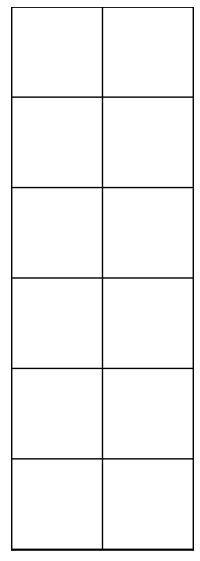

tensor(0.0450, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6309, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [8000/40000 (60%)]	 Loss: 1.306765
Batch ID: 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


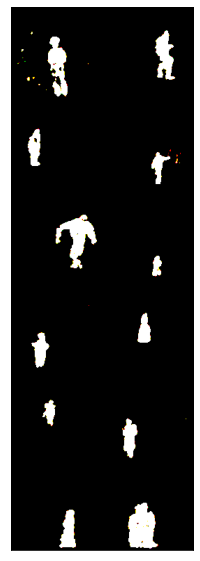

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


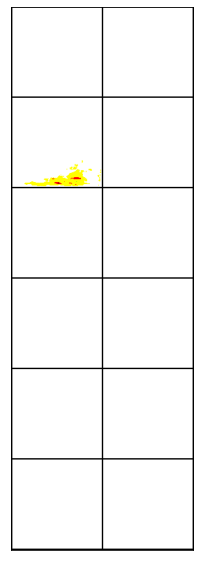

tensor(0.0507, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6490, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [8400/40000 (63%)]	 Loss: 1.348696
Batch ID: 2100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


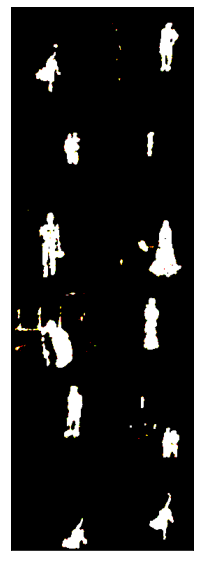

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


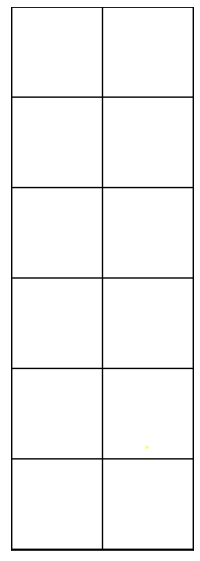

tensor(0.0743, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6448, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [8800/40000 (66%)]	 Loss: 1.363840
Batch ID: 2200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


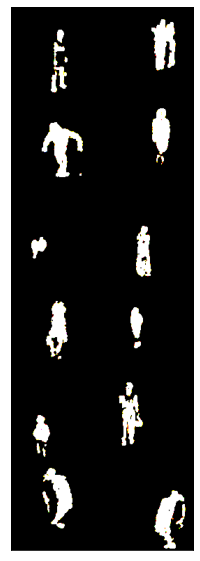

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


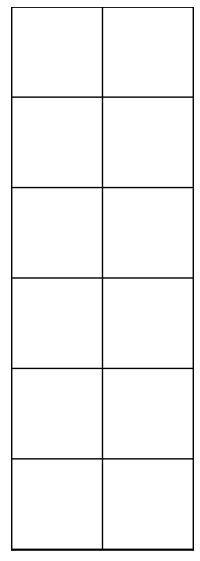

tensor(0.0509, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6353, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [9200/40000 (69%)]	 Loss: 1.321609
Batch ID: 2300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


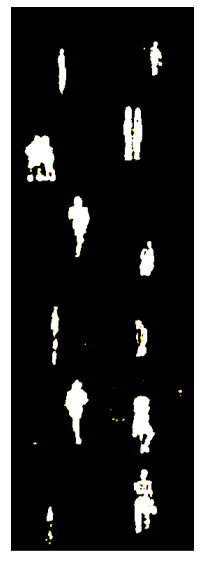

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


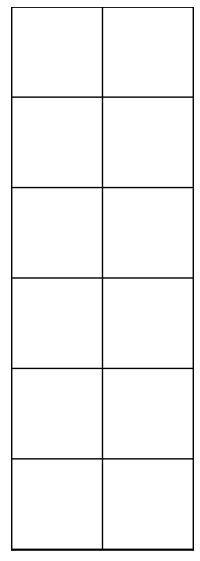

tensor(0.0438, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6345, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [9600/40000 (72%)]	 Loss: 1.312745
Batch ID: 2400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


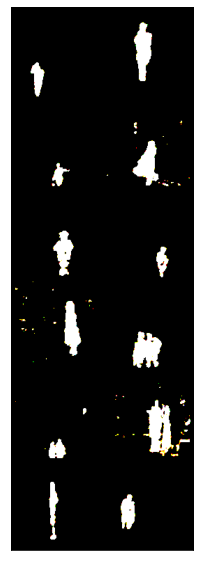

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


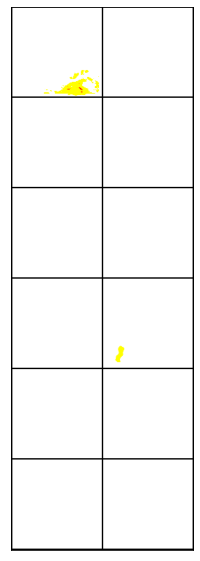

tensor(0.0546, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6323, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [10000/40000 (75%)]	 Loss: 1.319099
Batch ID: 2500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


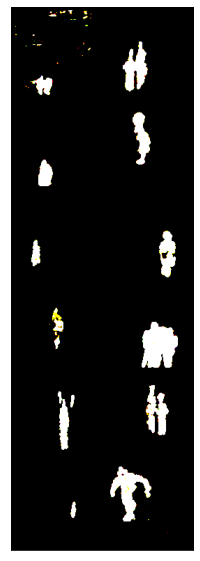

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


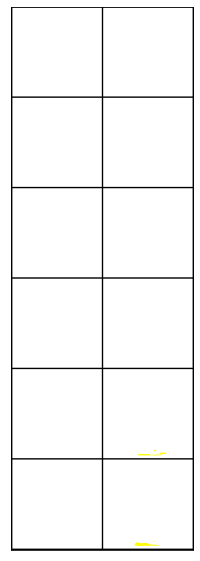

tensor(0.0401, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6051, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [10400/40000 (78%)]	 Loss: 1.250285
Batch ID: 2600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


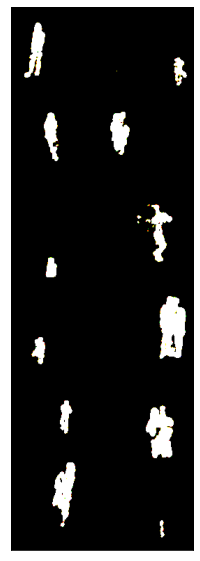

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


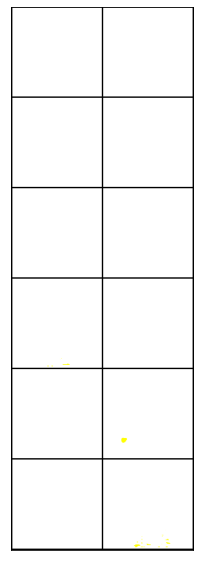

tensor(0.0411, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6304, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [10800/40000 (81%)]	 Loss: 1.301796
Batch ID: 2700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


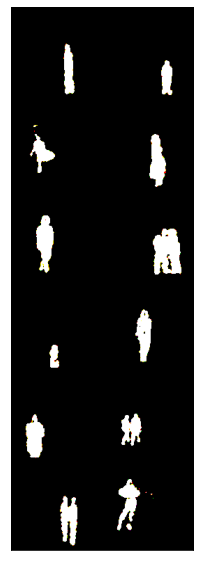

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


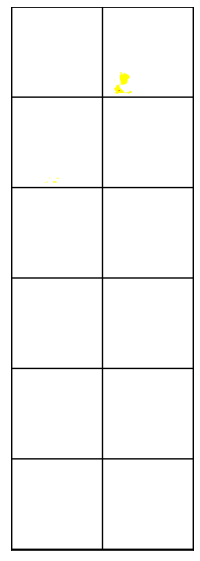

tensor(0.0526, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6332, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [11200/40000 (84%)]	 Loss: 1.319109
Batch ID: 2800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


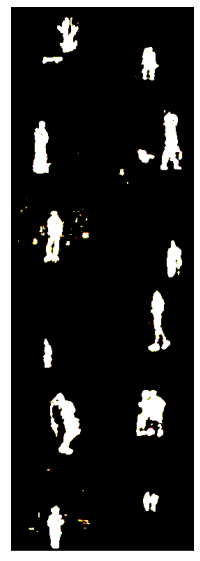

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


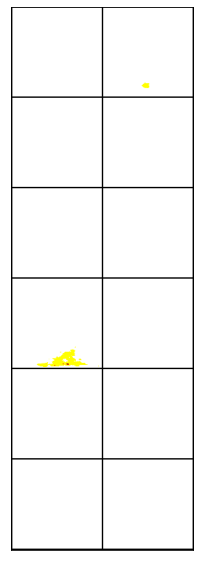

tensor(0.0558, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6346, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [11600/40000 (87%)]	 Loss: 1.324921
Batch ID: 2900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


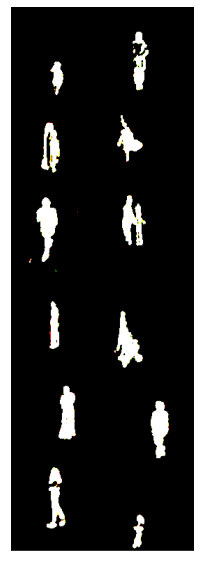

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


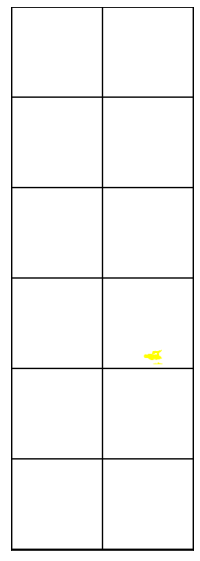

tensor(0.0364, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6510, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [12000/40000 (90%)]	 Loss: 1.338345
Batch ID: 3000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


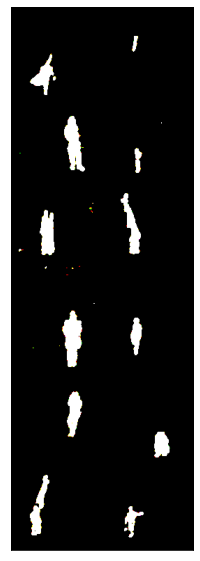

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


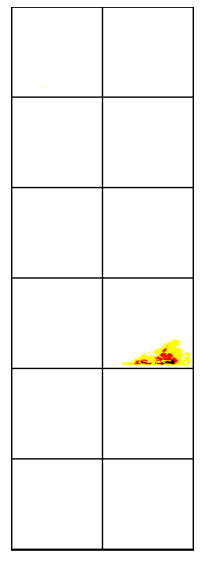

tensor(0.0469, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6355, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [12400/40000 (93%)]	 Loss: 1.317928
Batch ID: 3100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


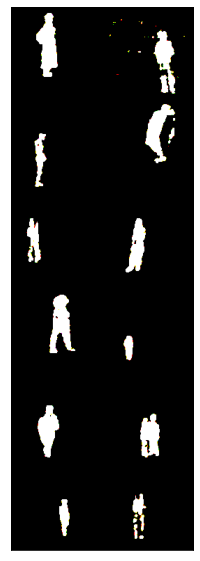

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


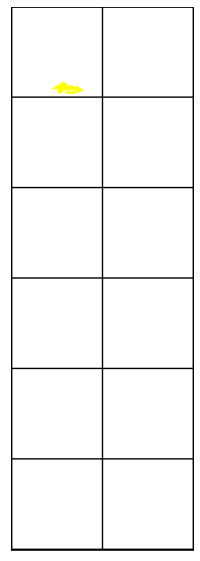

tensor(0.0528, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6102, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [12800/40000 (96%)]	 Loss: 1.273133
Batch ID: 3200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


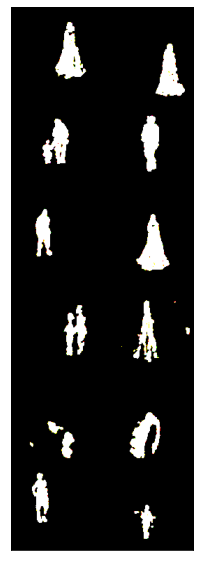

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


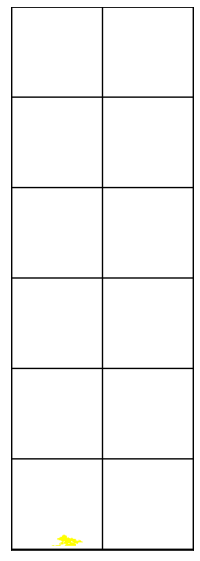

tensor(0.0366, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6602, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [13200/40000 (99%)]	 Loss: 1.356901
Batch ID: 3300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


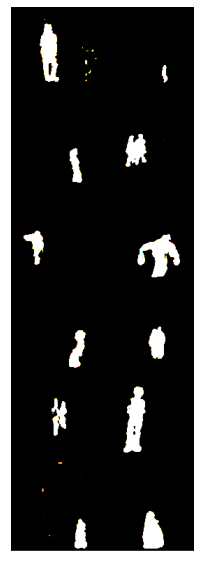

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


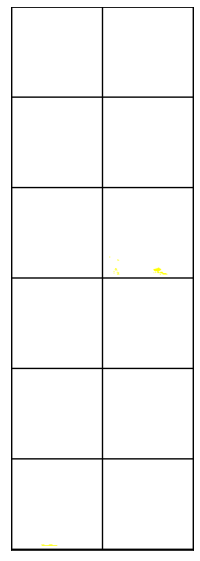

tensor(0.0451, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6120, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [0/40000 (0%)]	 Loss: 1.269126
Batch ID: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


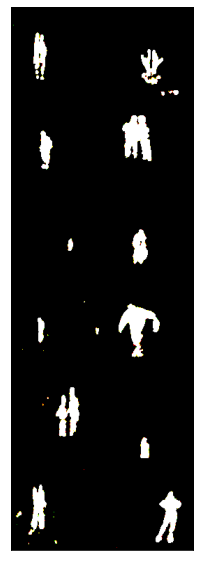

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


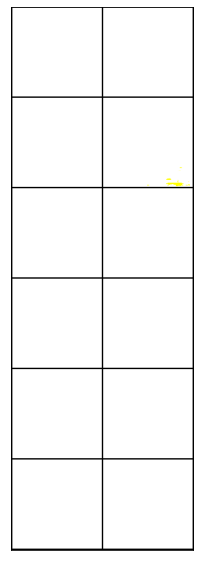

tensor(0.0401, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6331, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [400/40000 (3%)]	 Loss: 1.306413
Batch ID: 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


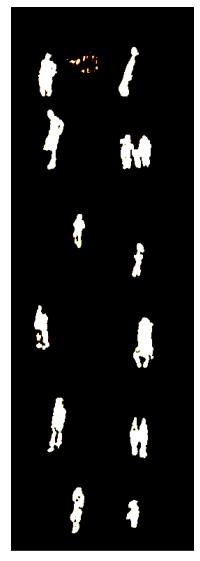

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


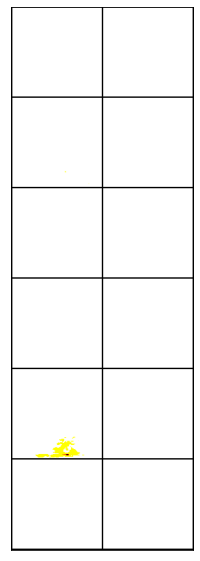

tensor(0.0579, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6172, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [800/40000 (6%)]	 Loss: 1.292239
Batch ID: 200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


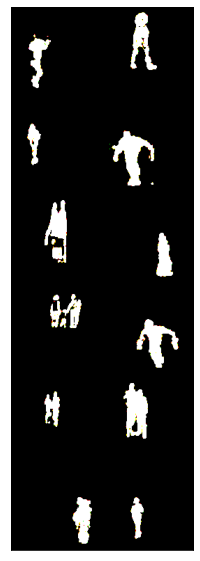

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


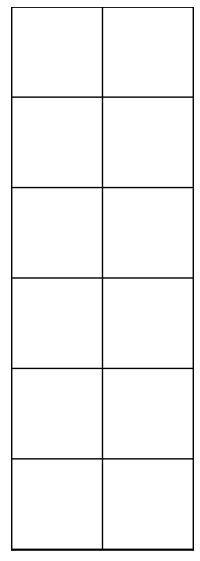

tensor(0.0491, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6467, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [1200/40000 (9%)]	 Loss: 1.342598
Batch ID: 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


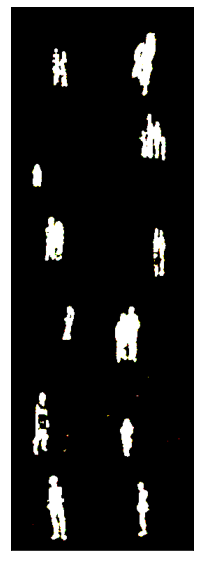

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


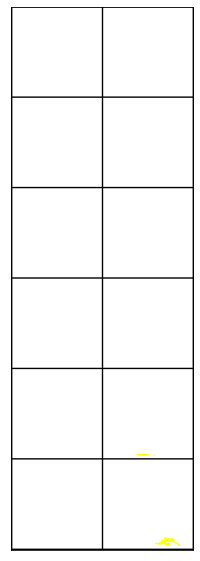

tensor(0.0446, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6087, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [1600/40000 (12%)]	 Loss: 1.261951
Batch ID: 400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


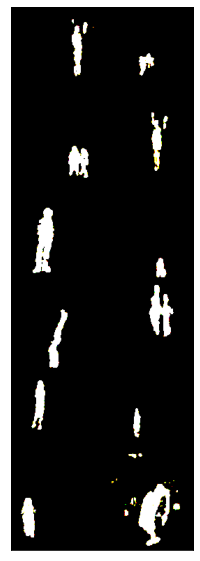

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


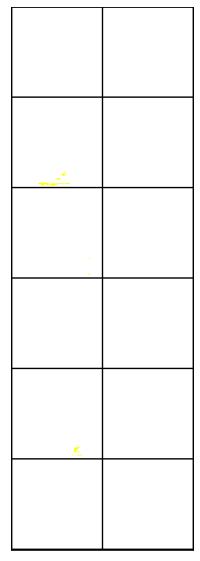

tensor(0.0572, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6323, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [2000/40000 (15%)]	 Loss: 1.321815
Batch ID: 500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


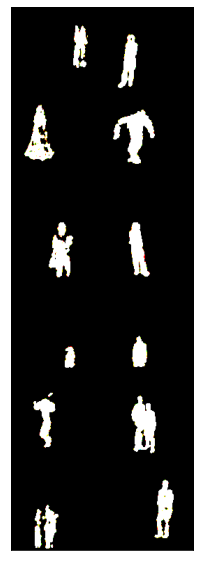

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


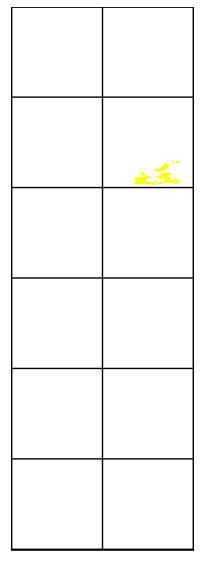

tensor(0.0425, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6449, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [2400/40000 (18%)]	 Loss: 1.332365
Batch ID: 600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


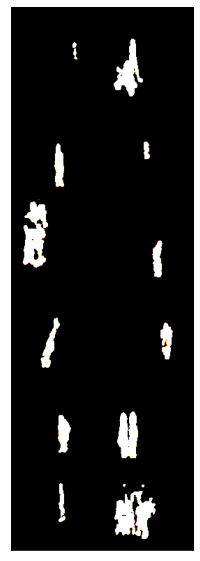

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


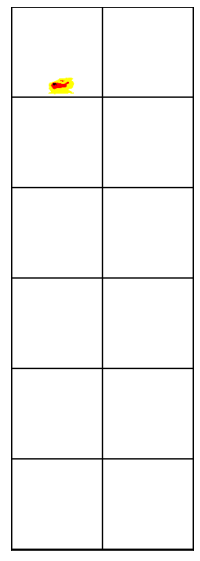

tensor(0.0455, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6482, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [2800/40000 (21%)]	 Loss: 1.341870
Batch ID: 700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


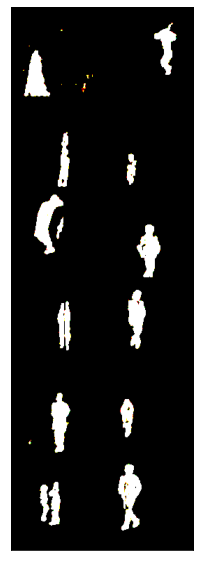

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


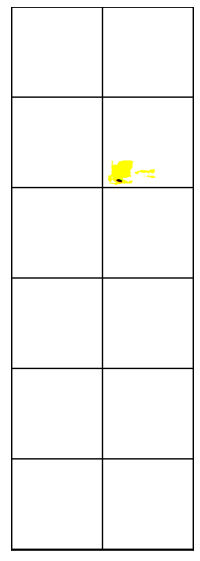

tensor(0.0516, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6371, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [3200/40000 (24%)]	 Loss: 1.325872
Batch ID: 800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


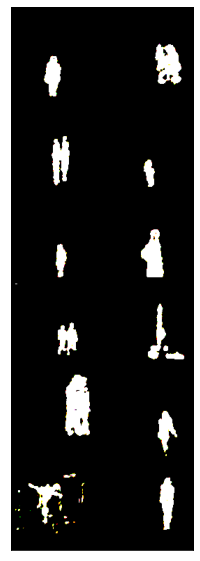

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


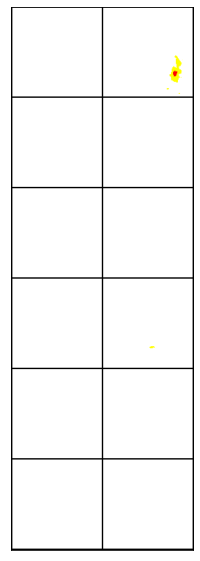

tensor(0.0362, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6279, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [3600/40000 (27%)]	 Loss: 1.292089
Batch ID: 900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


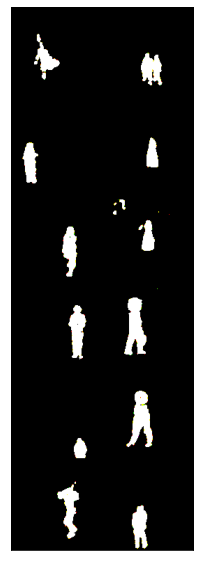

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


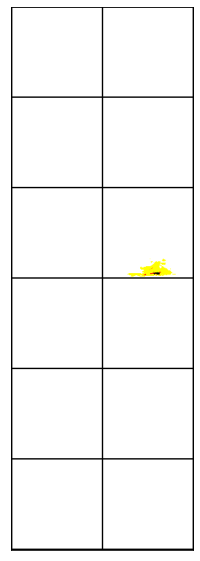

tensor(0.0512, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6330, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [4000/40000 (30%)]	 Loss: 1.317296
Batch ID: 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


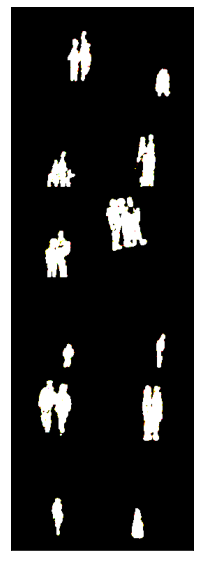

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


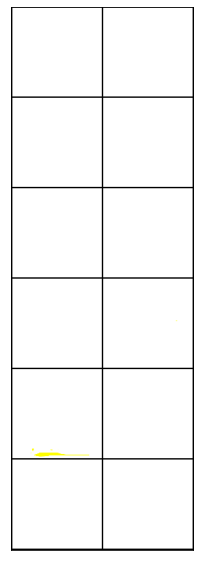

tensor(0.0381, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6435, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [4400/40000 (33%)]	 Loss: 1.325207
Batch ID: 1100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


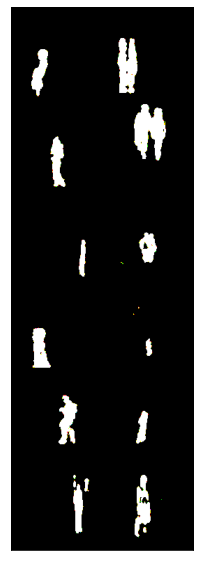

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


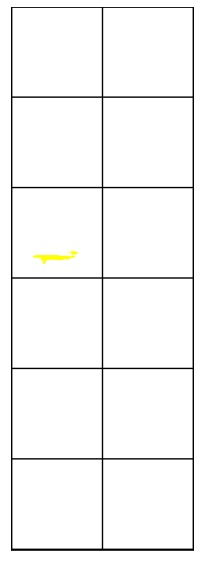

tensor(0.0653, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6493, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [4800/40000 (36%)]	 Loss: 1.363848
Batch ID: 1200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


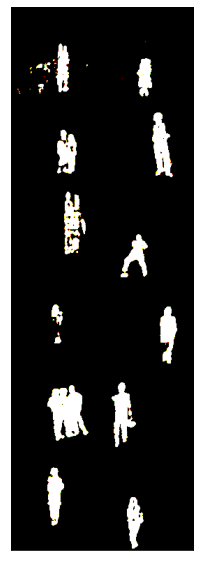

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


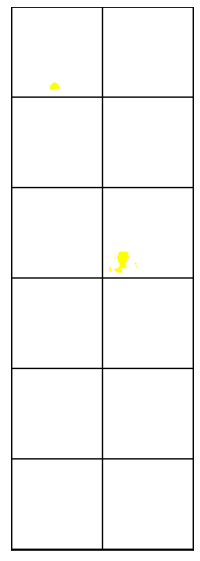

tensor(0.0441, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6280, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [5200/40000 (39%)]	 Loss: 1.300052
Batch ID: 1300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


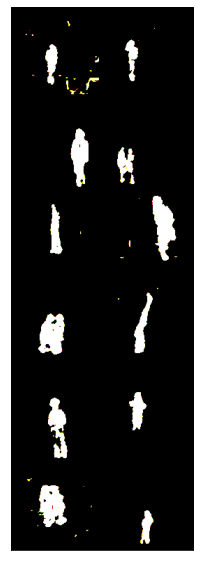

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


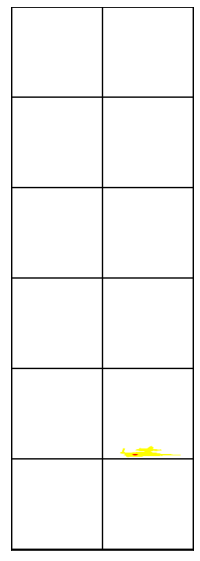

tensor(0.0413, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6292, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [5600/40000 (42%)]	 Loss: 1.299694
Batch ID: 1400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


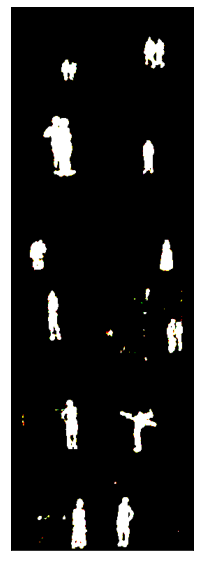

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


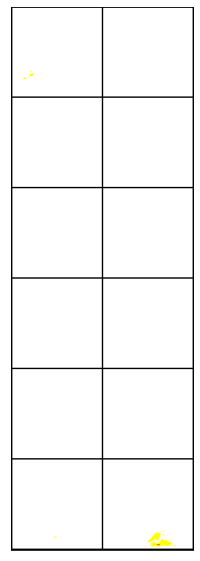

tensor(0.0514, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6471, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [6000/40000 (45%)]	 Loss: 1.345669
Batch ID: 1500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


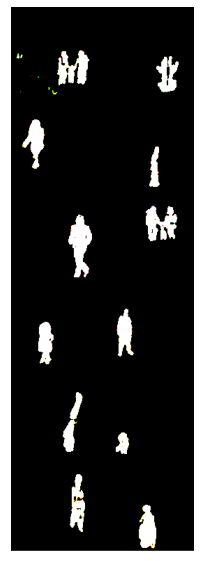

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


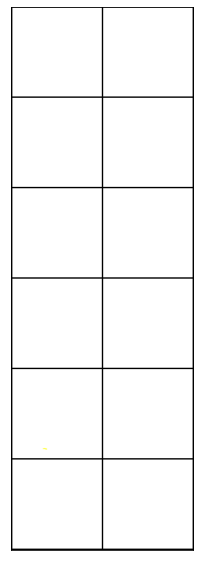

tensor(0.0510, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6414, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [6400/40000 (48%)]	 Loss: 1.333906
Batch ID: 1600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


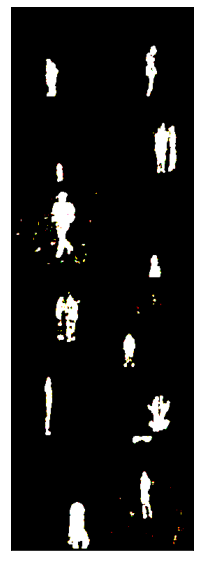

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


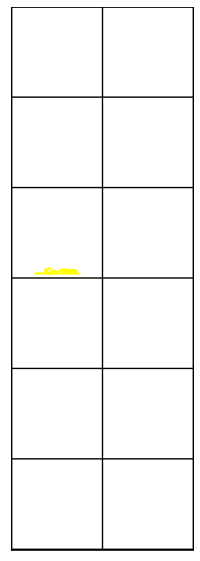

tensor(0.0480, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6308, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [6800/40000 (51%)]	 Loss: 1.309738
Batch ID: 1700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


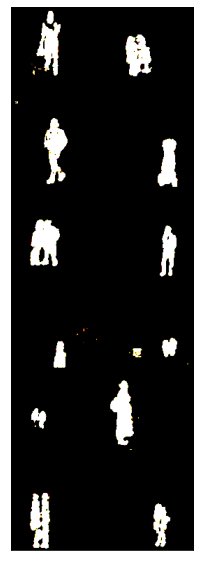

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


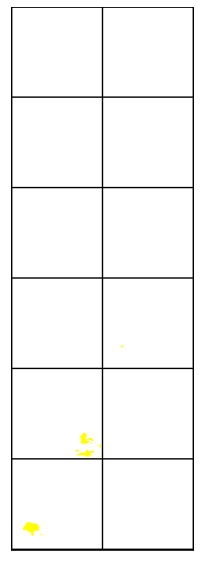

tensor(0.0522, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6417, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [7200/40000 (54%)]	 Loss: 1.335551
Batch ID: 1800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


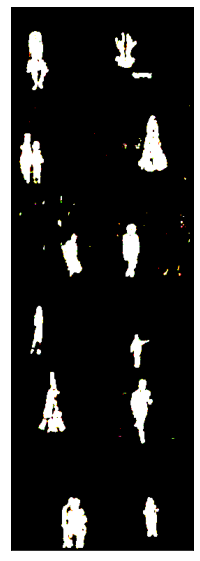

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


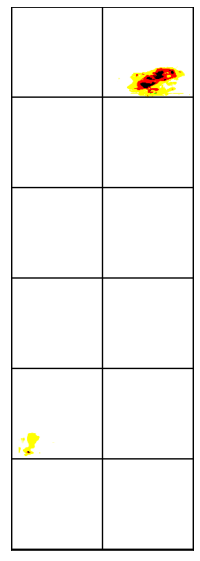

tensor(0.0619, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6429, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [7600/40000 (57%)]	 Loss: 1.347585
Batch ID: 1900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


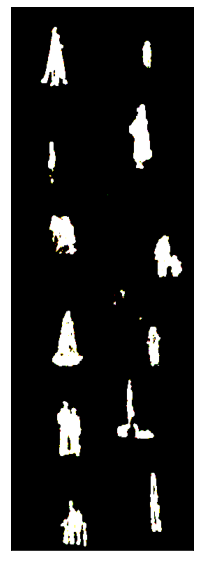

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


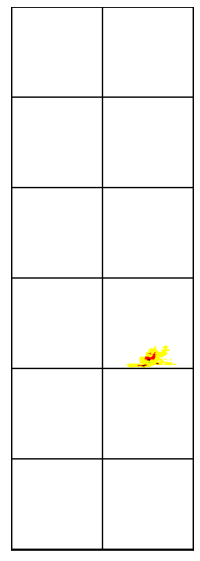

tensor(0.0431, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6290, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [8000/40000 (60%)]	 Loss: 1.301008
Batch ID: 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


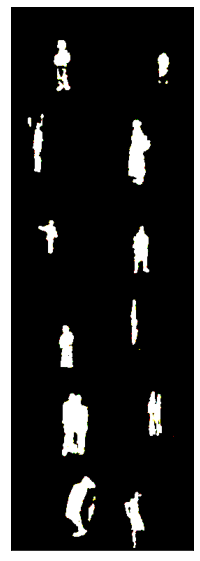

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


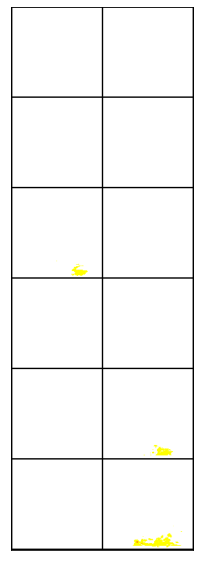

tensor(0.0575, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6376, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [8400/40000 (63%)]	 Loss: 1.332695
Batch ID: 2100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


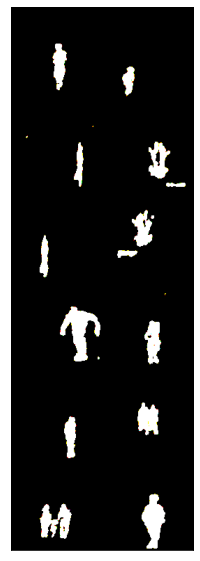

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


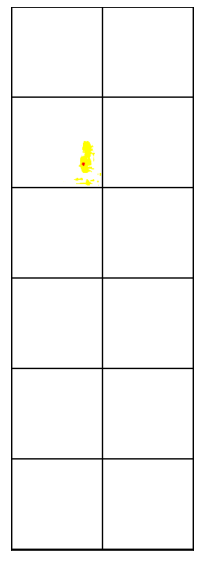

tensor(0.0419, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6381, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [8800/40000 (66%)]	 Loss: 1.318147
Batch ID: 2200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


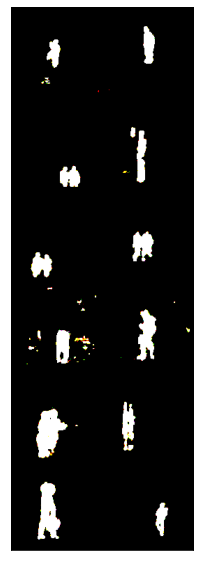

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


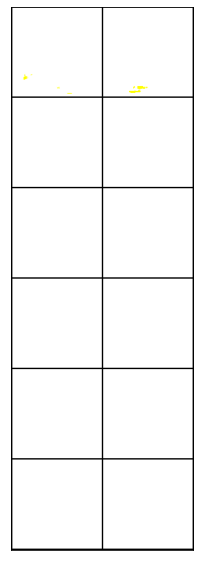

tensor(0.0473, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6156, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [9200/40000 (69%)]	 Loss: 1.278512
Batch ID: 2300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


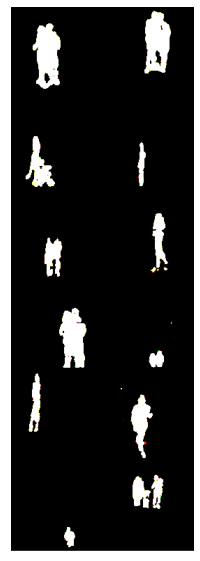

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


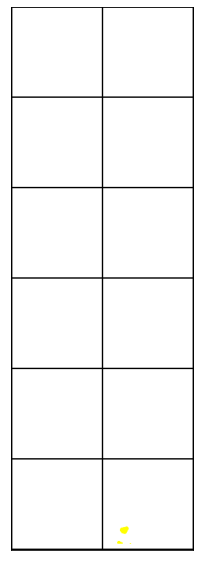

tensor(0.0449, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6357, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [9600/40000 (72%)]	 Loss: 1.316251
Batch ID: 2400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


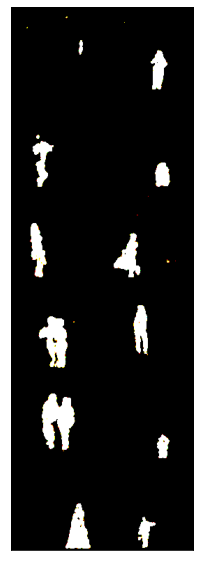

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


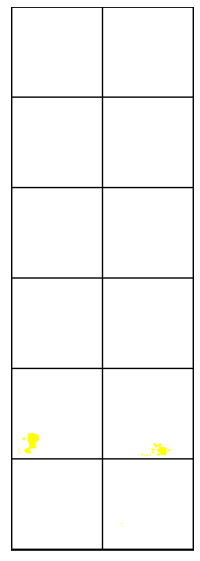

tensor(0.0390, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6152, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [10000/40000 (75%)]	 Loss: 1.269400
Batch ID: 2500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


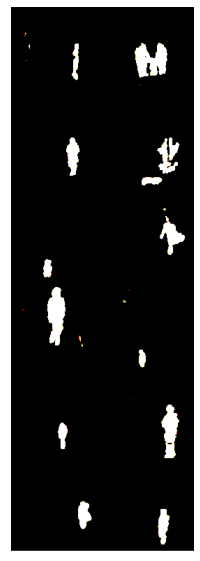

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


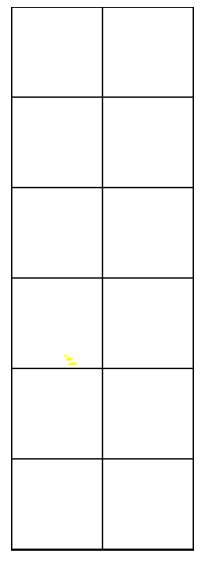

tensor(0.0406, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6037, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [10400/40000 (78%)]	 Loss: 1.248061
Batch ID: 2600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


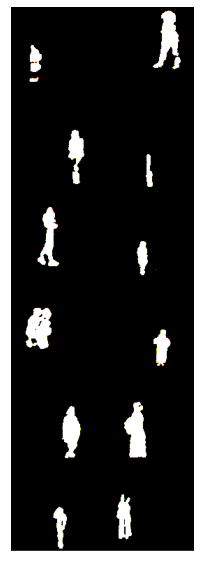

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


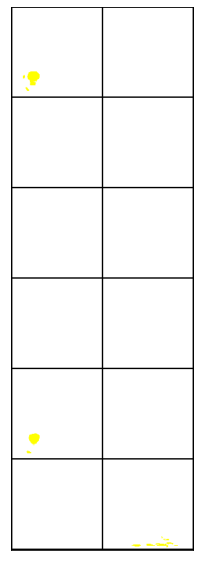

tensor(0.0553, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6632, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [10800/40000 (81%)]	 Loss: 1.381808
Batch ID: 2700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


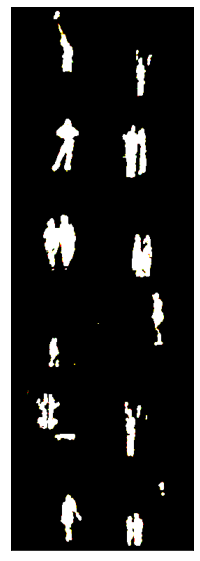

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


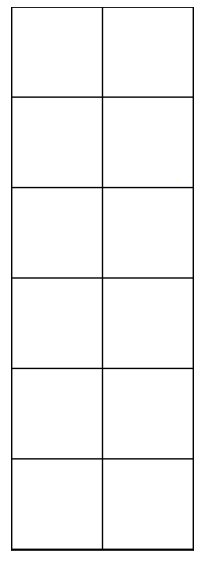

tensor(0.0565, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6330, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [11200/40000 (84%)]	 Loss: 1.322406
Batch ID: 2800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


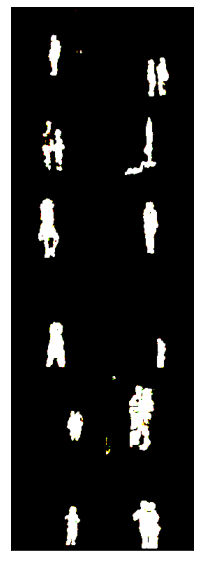

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


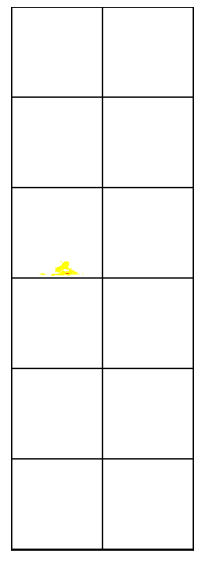

tensor(0.0445, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6267, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [11600/40000 (87%)]	 Loss: 1.297872
Batch ID: 2900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


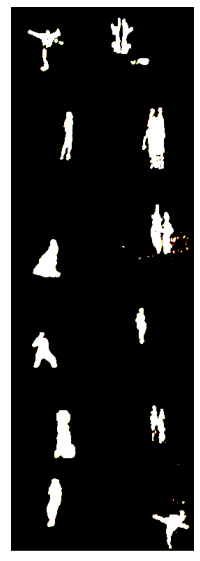

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


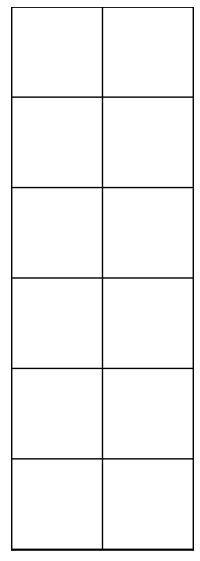

tensor(0.0487, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6362, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [12000/40000 (90%)]	 Loss: 1.321038
Batch ID: 3000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


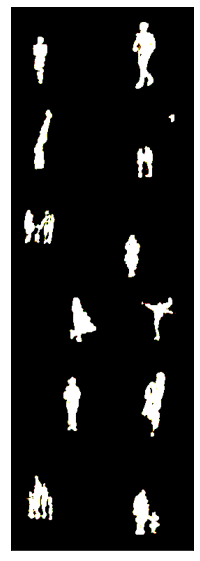

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


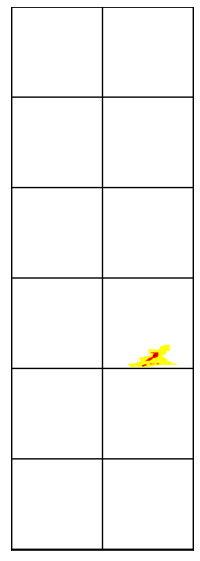

tensor(0.0379, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6304, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [12400/40000 (93%)]	 Loss: 1.298843
Batch ID: 3100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


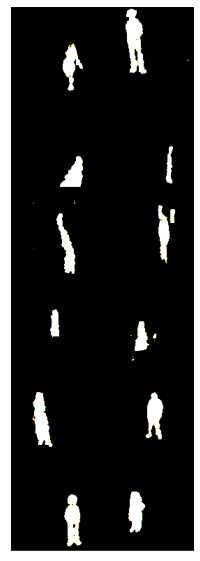

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


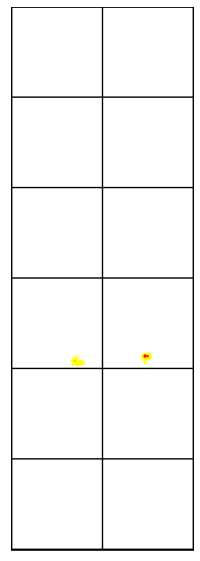

tensor(0.0514, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6175, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [12800/40000 (96%)]	 Loss: 1.286299
Batch ID: 3200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


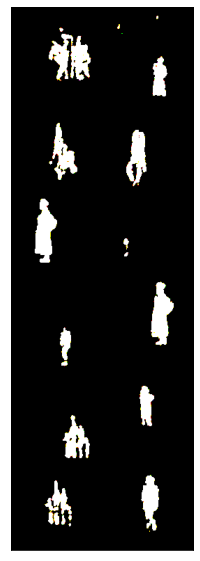

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


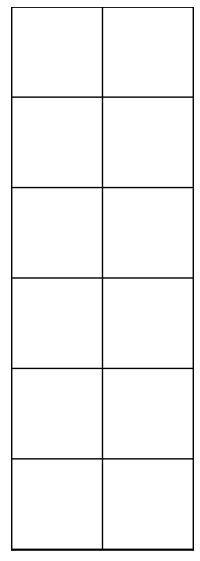

tensor(0.0503, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6401, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [13200/40000 (99%)]	 Loss: 1.330496
Batch ID: 3300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


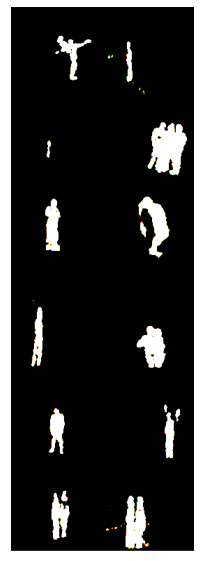

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


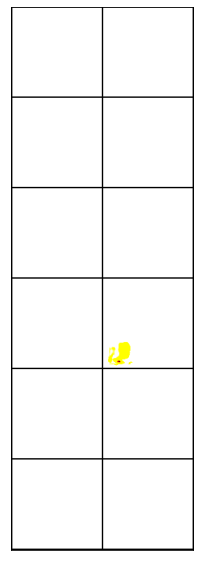

tensor(0.0431, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6345, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [0/40000 (0%)]	 Loss: 1.311998
Batch ID: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


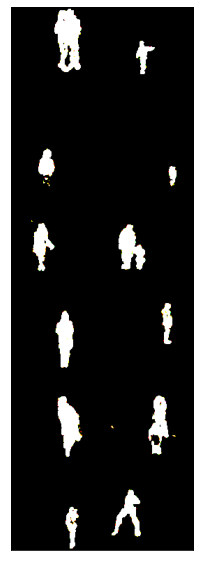

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


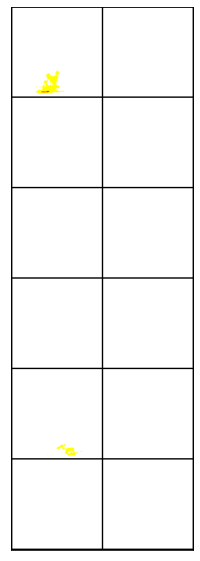

tensor(0.0525, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6370, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [400/40000 (3%)]	 Loss: 1.326539
Batch ID: 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


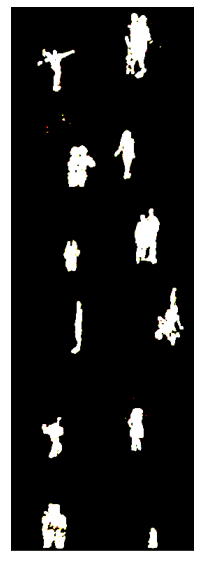

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


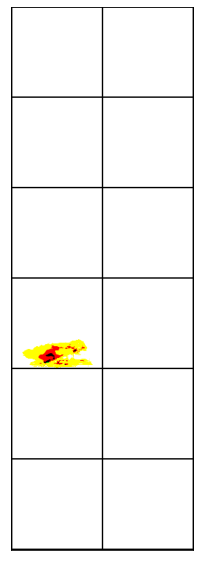

tensor(0.0373, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6295, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [800/40000 (6%)]	 Loss: 1.296233
Batch ID: 200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


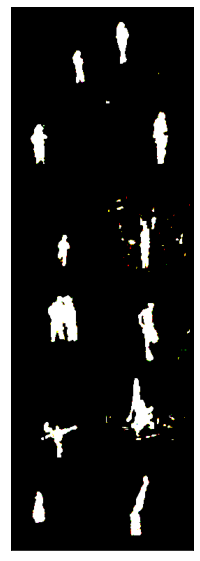

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


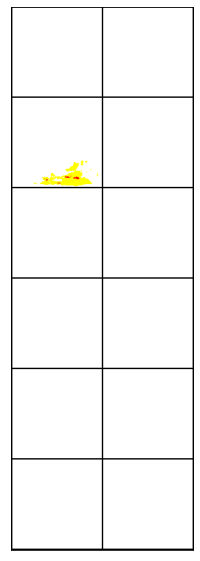

tensor(0.0543, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6383, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [1200/40000 (9%)]	 Loss: 1.330978
Batch ID: 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


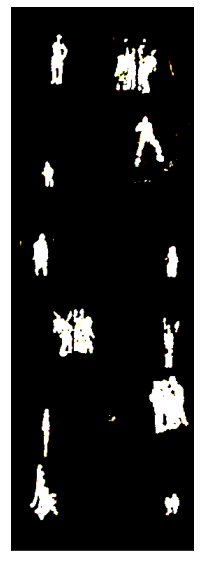

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


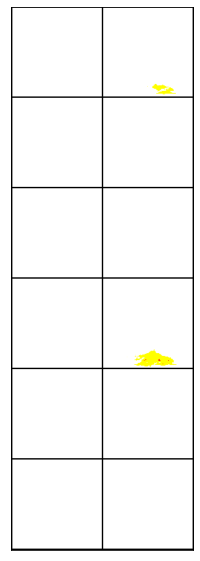

tensor(0.0404, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6480, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [1600/40000 (12%)]	 Loss: 1.336365
Batch ID: 400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


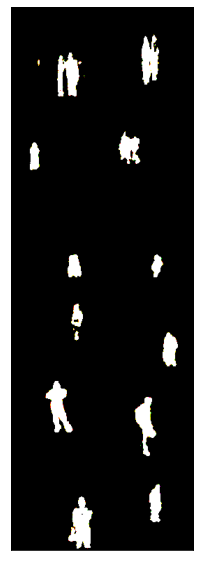

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


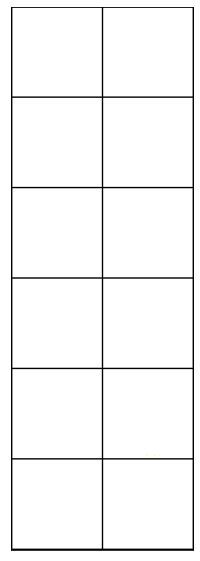

tensor(0.0565, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6380, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [2000/40000 (15%)]	 Loss: 1.332543
Batch ID: 500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


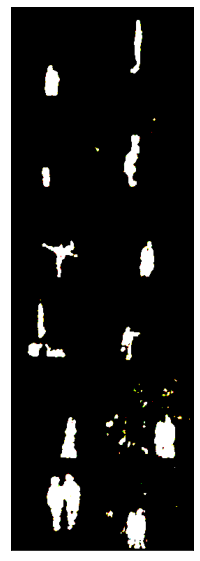

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


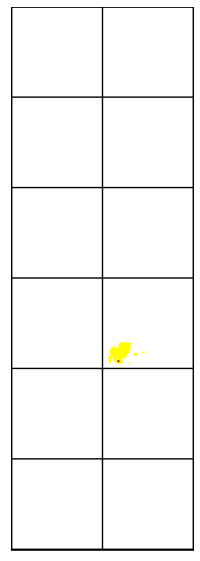

tensor(0.0491, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6320, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [2400/40000 (18%)]	 Loss: 1.313162
Batch ID: 600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


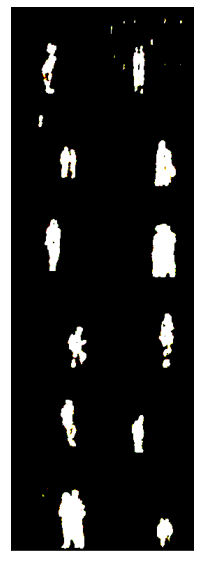

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


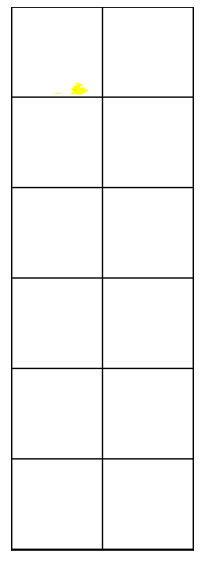

tensor(0.0460, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6350, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [2800/40000 (21%)]	 Loss: 1.315961
Batch ID: 700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


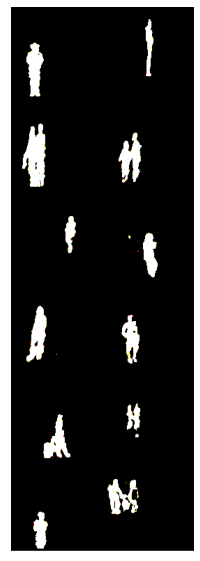

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


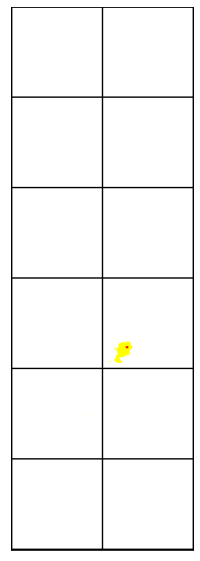

tensor(0.0466, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6251, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [3200/40000 (24%)]	 Loss: 1.296904
Batch ID: 800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


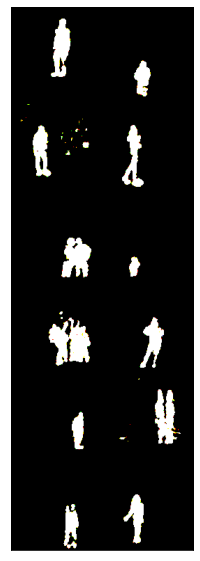

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


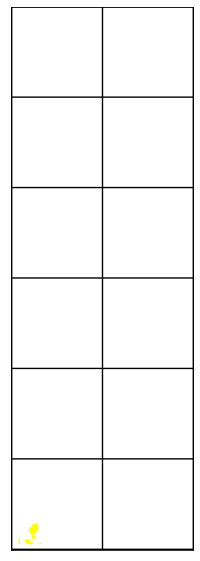

tensor(0.0496, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6162, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [3600/40000 (27%)]	 Loss: 1.281933
Batch ID: 900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


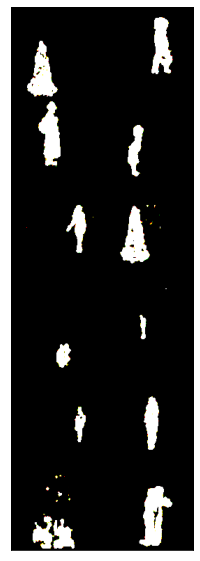

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


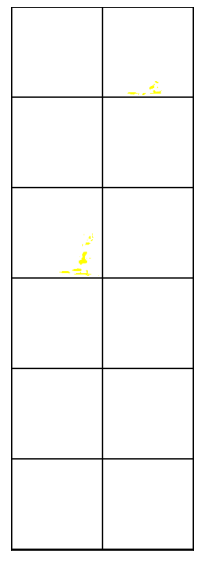

tensor(0.0506, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6311, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [4000/40000 (30%)]	 Loss: 1.312801
Batch ID: 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


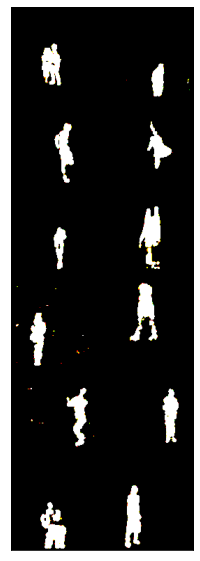

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


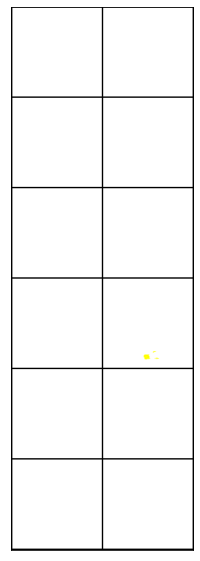

tensor(0.0503, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6204, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [4400/40000 (33%)]	 Loss: 1.291136
Batch ID: 1100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


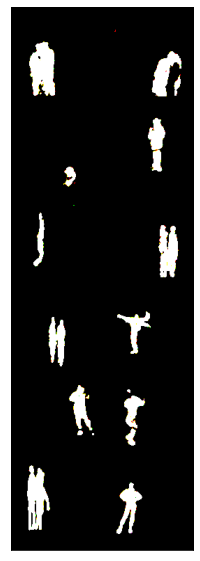

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


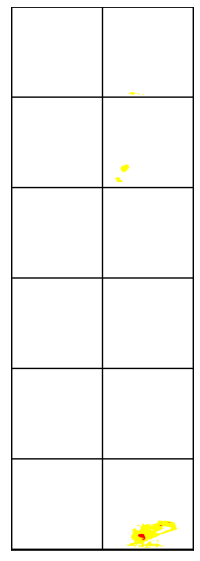

tensor(0.0475, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6164, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [4800/40000 (36%)]	 Loss: 1.280346
Batch ID: 1200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


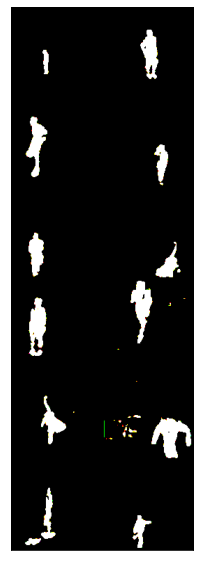

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


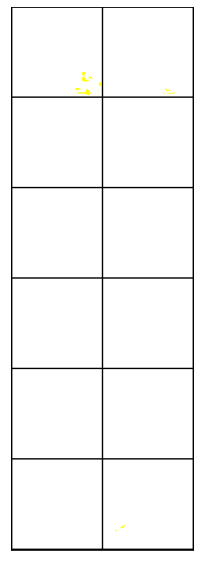

tensor(0.0542, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6199, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [5200/40000 (39%)]	 Loss: 1.294097
Batch ID: 1300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


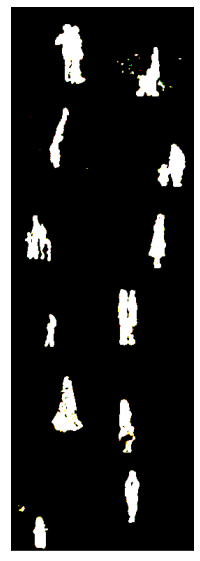

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


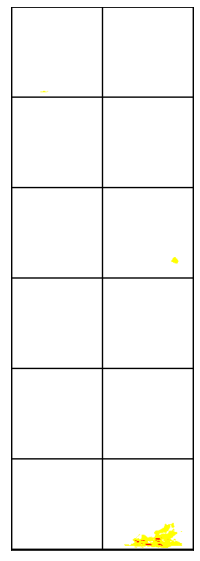

tensor(0.0390, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6310, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [5600/40000 (42%)]	 Loss: 1.301082
Batch ID: 1400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


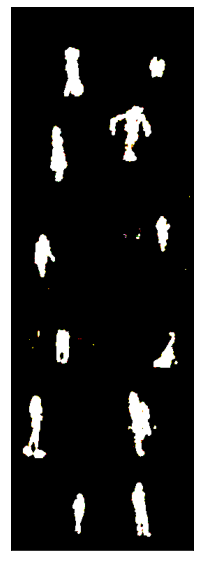

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


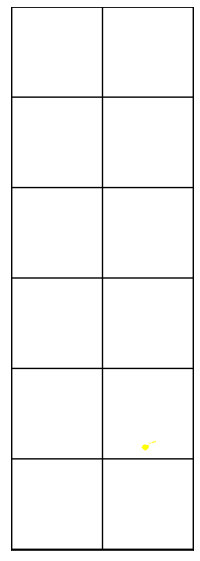

tensor(0.0365, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.5937, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [6000/40000 (45%)]	 Loss: 1.223900
Batch ID: 1500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


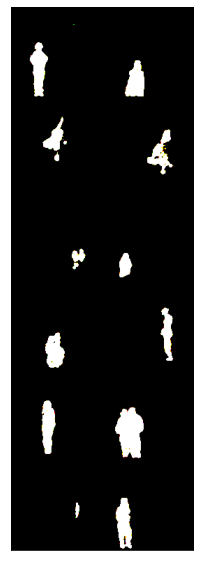

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


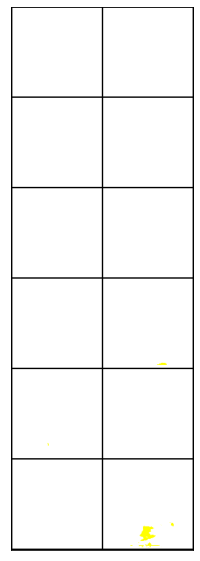

tensor(0.0469, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6255, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [6400/40000 (48%)]	 Loss: 1.297828
Batch ID: 1600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


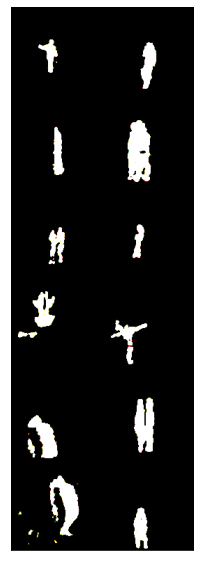

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


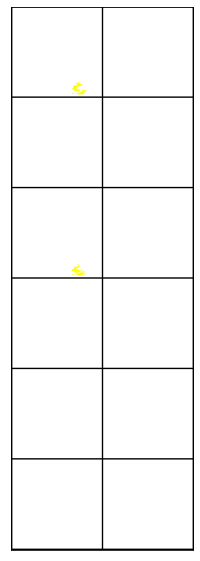

tensor(0.0451, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6447, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [6800/40000 (51%)]	 Loss: 1.334408
Batch ID: 1700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


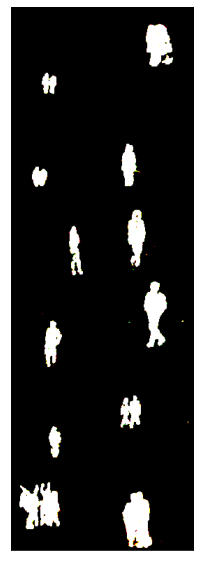

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


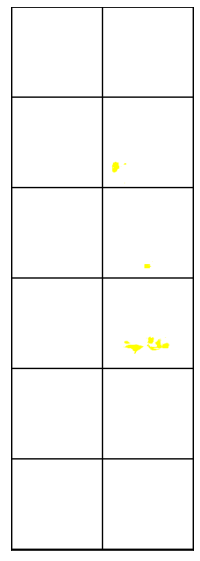

tensor(0.0474, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6315, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [7200/40000 (54%)]	 Loss: 1.310488
Batch ID: 1800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


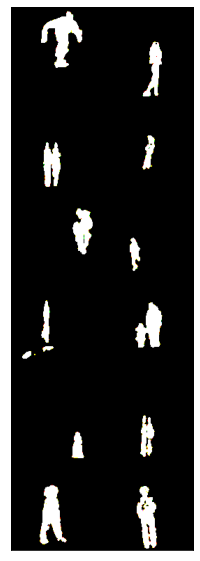

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


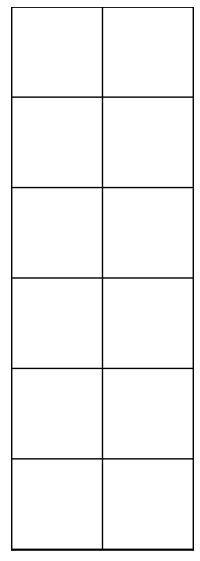

tensor(0.0335, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6221, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [7600/40000 (57%)]	 Loss: 1.277651
Batch ID: 1900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


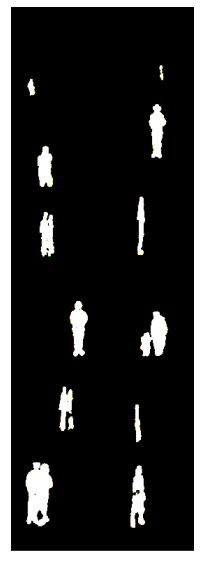

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


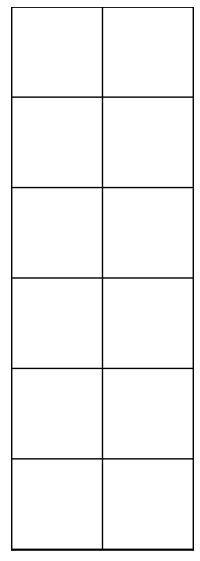

tensor(0.0487, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6159, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [8000/40000 (60%)]	 Loss: 1.280493
Batch ID: 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


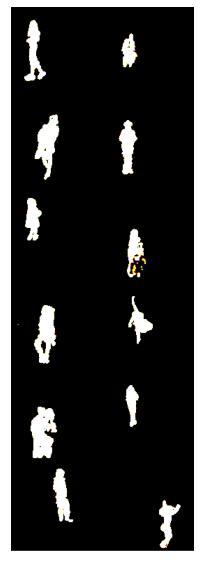

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


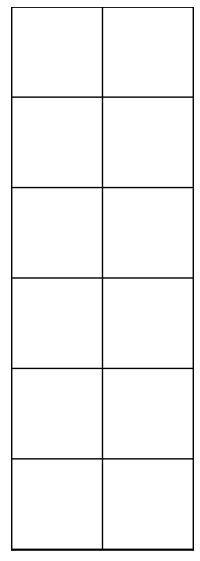

tensor(0.0436, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6056, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [8400/40000 (63%)]	 Loss: 1.254721
Batch ID: 2100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


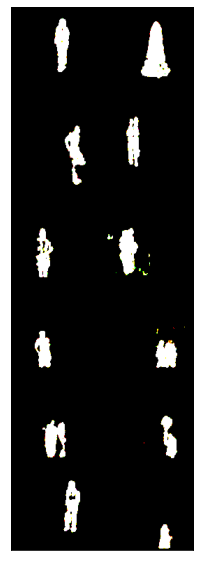

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


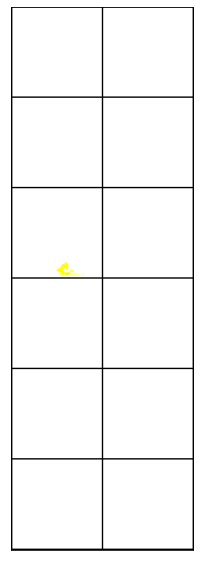

tensor(0.0614, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6315, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [8800/40000 (66%)]	 Loss: 1.324512
Batch ID: 2200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


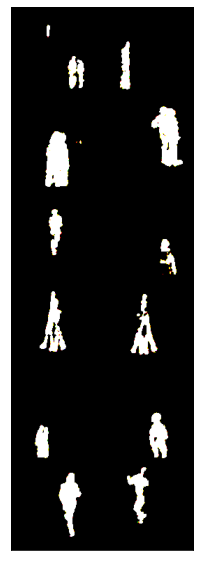

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


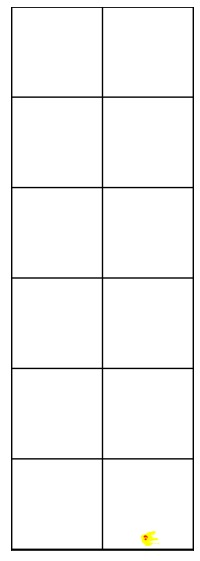

tensor(0.0396, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6409, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [9200/40000 (69%)]	 Loss: 1.321370
Batch ID: 2300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


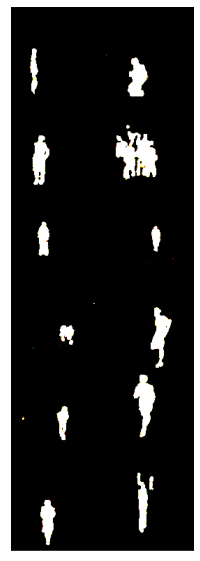

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


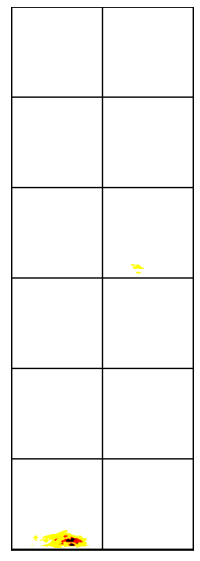

tensor(0.0423, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6337, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [9600/40000 (72%)]	 Loss: 1.309644
Batch ID: 2400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


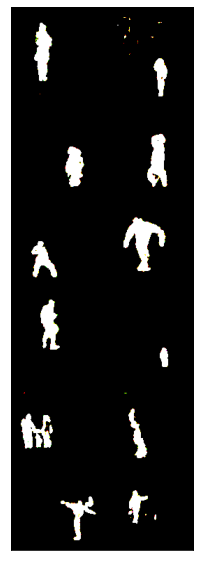

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


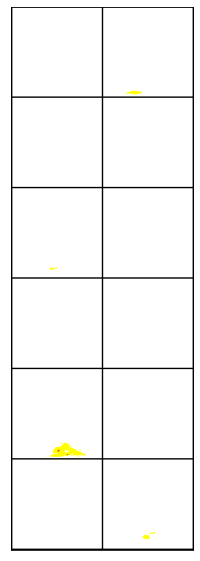

tensor(0.0539, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6155, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [10000/40000 (75%)]	 Loss: 1.284974
Batch ID: 2500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


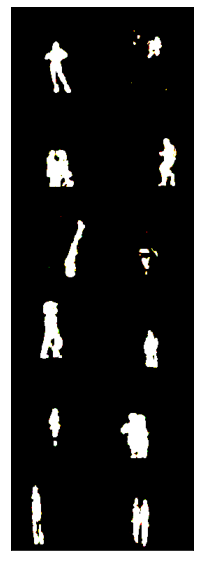

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


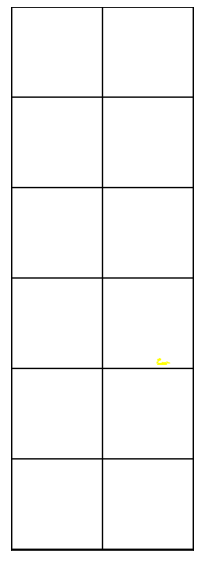

tensor(0.0444, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6385, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [10400/40000 (78%)]	 Loss: 1.321285
Batch ID: 2600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


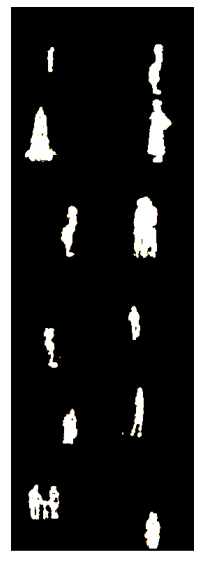

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


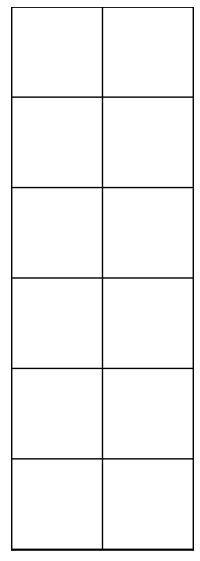

tensor(0.0497, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6492, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [10800/40000 (81%)]	 Loss: 1.348125
Batch ID: 2700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


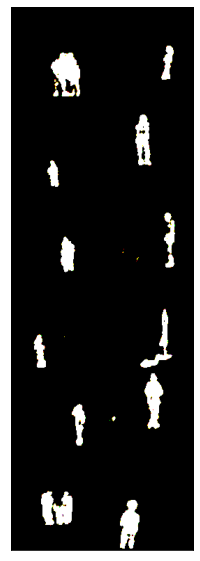

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


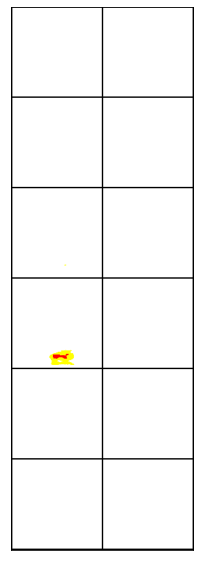

tensor(0.0467, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6098, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [11200/40000 (84%)]	 Loss: 1.266274
Batch ID: 2800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


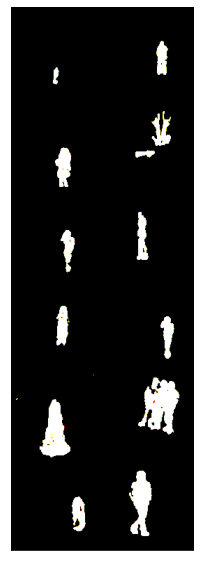

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


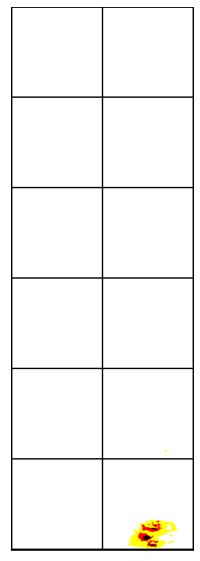

In [0]:
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

scheduler = StepLR(optim, step_size=2, gamma=0.01)
for epoch in range(1, 10):
    train(model, criterion, device, train_loader, optim, epoch)
    scheduler.step()

In [0]:
from tensorboardX import SummaryWriter 

In [0]:
writer = SummaryWriter() # Saves the summaries to default directory names 'runs' in the current parent directory 


In [0]:
def tensorboardImage(tensors, *args, **kwargs):
    mean, std = torch.tensor([0.485, 0.456, 0.406])*255, torch.tensor([0.229, 0.224, 0.225])*255
    tensors = (tensors * std[None, :, None, None]) + mean[None, :, None, None]
    try:
        tensors = tensors.detach().cpu()
    except:
        pass
    grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)
    return grid_tensor

In [0]:
%load_ext tensorboard


In [23]:
# %reload_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

In [0]:
kernel_size=3
criterion = SSIM(kernel_size, reduction="mean")


In [160]:
model = ResNetInspired(BasicBlock, [1,1,1,1]).to(device)
summary(model, (3, 128, 128))

skip1 shape:torch.Size([2, 64, 128, 128])
skip2 shape:torch.Size([2, 128, 64, 64])
skip3 shape:torch.Size([2, 256, 32, 32])
skip4 shape:torch.Size([2, 512, 16, 16])
skip5 shape:torch.Size([2, 1024, 8, 8])
Up1 Shapetorch.Size([2, 512, 16, 16])
Concat1 Shapetorch.Size([2, 512, 16, 16])
Up2 Shapetorch.Size([2, 256, 32, 32])
Concat2 Shapetorch.Size([2, 256, 32, 32])
Up3 Shapetorch.Size([2, 128, 64, 64])
Concat3 Shapetorch.Size([2, 128, 64, 64])
Up4 Shapetorch.Size([2, 64, 128, 128])
Concat4 Shapetorch.Size([2, 128, 128, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
            Conv2d-5         [-1, 64, 128, 128]           2,048
       BatchNorm2d-6   